# **Objective**: 
## Build a robust predictive model to estimate the `log_price` of homestay listings based on comprehensive analysis of their characteristics, amenities, and host information.
First make sure that the entire dataset is clean and ready to be used.

In [247]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np

In [248]:
# import data
df = pd.read_csv('Homestays_Data.csv')

In [249]:
# preview data
# df.head() to check the first 5 rows
# df.tail() to check the last 5 rows
dfo = df.copy()
df.tail()

id  log_price property_type        room_type  \
74106  14549287   4.605170     Apartment     Private room   
74107  13281809   5.043425     Apartment  Entire home/apt   
74108  18688039   5.220356     Apartment  Entire home/apt   
74109  17045948   5.273000     Apartment  Entire home/apt   
74110   3534845   4.852030          Boat  Entire home/apt   

                                               amenities  accommodates  \
74106                                                 {}             1   
74107  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4   
74108  {TV,Internet,"Wireless Internet","Air conditio...             5   
74109  {TV,"Wireless Internet","Air conditioning",Kit...             2   
74110  {TV,Internet,"Wireless Internet",Kitchen,"Free...             4   

       bathrooms  bed_type cancellation_policy  cleaning_fee  ...   latitude  \
74106        1.0  Real Bed            flexible         False  ...  40.709025   
74107        2.0  Real Bed            moderate          True  ...  33.871549   
74108        1.0  Real Bed            moderate          True  ...  40.706749   
74109        1.0  Real Bed              strict          True  ...  40.738535   
74110        1.0  Real Bed            moderate         False  ...  33.761096   

        longitude                                        name  neighbourhood  \
74106  -73.939405                           one room bushwick   Williamsburg   
74107 -118.396053                Spacious Hermosa 2 BR on PCH  Hermosa Beach   
74108  -73.942377  Modern 2 Bedroom Apartment in Williamsburg   Williamsburg   
74109  -74.000157        Designer's Apartment in HEART of NYC   West Village   
74110 -118.192409              Cozy Boat at Shoreline Village     Long Beach   

      number_of_reviews review_scores_rating  \
74106                 0                  NaN   
74107                16                 93.0   
74108                43                 94.0   
74109                 0                  NaN   
74110               205                 96.0   

                                           thumbnail_url zipcode bedrooms  \
74106  https://a0.muscache.com/im/pictures/55162426/6...   11206      1.0   
74107  https://a0.muscache.com/im/pictures/2b86560b-a...   90254      2.0   
74108  https://a0.muscache.com/im/pictures/7fbe448c-5...   11206      2.0   
74109  https://a0.muscache.com/im/pictures/b3971b63-0...   10011      0.0   
74110  https://a0.muscache.com/im/pictures/22968537/d...   90802      1.0   

       beds  
74106   1.0  
74107   4.0  
74108   2.0  
74109   2.0  
74110   2.0  

[5 rows x 29 columns]

In [250]:
# checking data types for various features
# dtypes: bool(1), float64(7), int64(3), object(18)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [251]:
# initial size
df.shape

(74111, 29)

In [252]:
'''
checking which features contain blank, null or empty values:
We can check for missing values with pandas isnull(). 
This indicates whether values are missing or not. 
Then we can sum all the values to check every column.
'''
# df.isnull().sum()
round((df.isnull().sum()/df.shape[0])*100,2)

id                         0.00
log_price                  0.00
property_type              0.00
room_type                  0.00
amenities                  0.00
accommodates               0.00
bathrooms                  0.27
bed_type                   0.00
cancellation_policy        0.00
cleaning_fee               0.00
city                       0.00
description                0.00
first_review              21.41
host_has_profile_pic       0.25
host_identity_verified     0.25
host_response_rate        24.69
host_since                 0.25
instant_bookable           0.00
last_review               21.36
latitude                   0.00
longitude                  0.00
name                       0.00
neighbourhood              9.27
number_of_reviews          0.00
review_scores_rating      22.56
thumbnail_url             11.09
zipcode                    1.30
bedrooms                   0.12
beds                       0.18
dtype: float64

In [253]:
# handling the null values: 
# drop the thumbnail_url and zipcode as they are not important factors

df = df.drop(columns='id')
df = df.drop(columns='name')
df = df.drop(columns='thumbnail_url')
df = df.drop(columns='zipcode')

# drop null rows whose observation columns having null values
df = df[~pd.isnull(df['bathrooms'])]
df = df[~pd.isnull(df['first_review'])]
df = df[~pd.isnull(df['host_has_profile_pic'])]
df = df[~pd.isnull(df['host_identity_verified'])]
df = df[~pd.isnull(df['host_since'])]
df = df[~pd.isnull(df['last_review'])]
df = df[~pd.isnull(df['neighbourhood'])]
df = df[~pd.isnull(df['bedrooms'])]
df = df[~pd.isnull(df['beds'])]

# dropping rows having less than 450 entries as it won't affect log_price much
df = df.groupby("property_type").filter(lambda x: len(x)>=450)

df.shape

(50753, 25)

In [254]:
# replacing unwanted symbols of object and converting to int64
df['host_response_rate'] = df['host_response_rate'].replace({'%':''}, regex=True)
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df = df.astype({'host_response_rate': int})
df['host_response_rate']

0          0
1        100
2        100
4        100
5        100
        ... 
74097    100
74100    100
74103    100
74107    100
74108    100
Name: host_response_rate, Length: 50753, dtype: int32

In [255]:
'''
Inputing the missing values from past observations.
Again, “missingness” is almost always informative in itself, and you should tell your algorithm if a value was missing by reinforcing the patterns already provided by other features.
Mean imputation or Median imputations is used here.
Note: 
Mean imputation is suitable when the data is normally distributed and has no extreme outliers.
Median imputation is preferable when the data contains outliers or is skewed.
'''
# performing mean imputation for observations having % null between 9% and 25%
df = df.fillna(df.host_response_rate.mean())
df = df.fillna(df.review_scores_rating.mean())

df.shape

(50753, 25)

In [256]:
# recheck if the data is cleaned or not
# df.isnull().sum()
round((df.isnull().sum()/df.shape[0])*100,2)

log_price                 0.0
property_type             0.0
room_type                 0.0
amenities                 0.0
accommodates              0.0
bathrooms                 0.0
bed_type                  0.0
cancellation_policy       0.0
cleaning_fee              0.0
city                      0.0
description               0.0
first_review              0.0
host_has_profile_pic      0.0
host_identity_verified    0.0
host_response_rate        0.0
host_since                0.0
instant_bookable          0.0
last_review               0.0
latitude                  0.0
longitude                 0.0
neighbourhood             0.0
number_of_reviews         0.0
review_scores_rating      0.0
bedrooms                  0.0
beds                      0.0
dtype: float64

# Feature Engineering:
# Task: Enhance the dataset by creating actionable and insightful features. 
Calculate `Host_Tenure` by determining the number of years from `host_since` to the current date, providing a measure of host experience. Generate `Amenities_Count` by counting the items listed in the `amenities` array to quantify property offerings. Determine `Days_Since_Last_Review` by calculating the days between `last_review` and today to assess listing activity and relevance.

In [257]:
# host and amenities features: 
# adding necessary columns
df.insert(0, 'host_tenure', 0)
df.insert(1, 'days_since_last_review', 0)

In [258]:
# Filling the added columns
today_date = pd.to_datetime(pd.to_datetime("today").date())

# host_tenure
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_tenure'] = (today_date - df['host_since'])
df['host_tenure'] = df[['host_tenure']].apply(pd.to_numeric)
df['host_tenure'] = df['host_tenure']/(24*60*60*1e9)
df['host_tenure'] = df['host_tenure'].astype(int)

# days_since_last_review
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_last_review'] = (today_date - df['last_review'])
df['days_since_last_review'] = df[['days_since_last_review']].apply(pd.to_numeric)
df['days_since_last_review'] = df['days_since_last_review']/(24*60*60*1e9)
df['days_since_last_review'] = df['days_since_last_review'].astype(int)


In [259]:
# # extract amenities
# amenities_list = []
# for i in range(len(df['amenities'].unique())):
#     if not pd.isnull(df['amenities'].unique()[i]):
#         amenities = df['amenities'].unique()[i].split(",")
#         for ft in amenities:
#             if ft not in amenities_list:
#                 amenities_list.append(ft)
# amenities_list

####### commented out since running it takes quite a lot of time #######
''' 
amenities_list = ['{"Wireless Internet"',
 '"Air conditioning"',
 'Kitchen',
 'Heating',
 '"Family/kid friendly"',
 'Essentials',
 '"Hair dryer"',
 'Iron',
 '"translation missing: en.hosting_amenity_50"}',
 'Washer',
 'Dryer',
 '"Smoke detector"',
 '"Fire extinguisher"',
 'Shampoo',
 'Hangers',
 '{TV',
 '"Cable TV"',
 '"Wireless Internet"',
 'Breakfast',
 '"Buzzer/wireless intercom"',
 '"Carbon monoxide detector"',
 '"Laptop friendly workspace"',
 'Internet',
 '"Elevator in building"',
 'Shampoo}',
 '"First aid kit"',
 '"Laptop friendly workspace"}',
 '"Wheelchair accessible"',
 'Pool',
 '"Free parking on premises"',
 'Doorman',
 'Dog(s)',
 'Cat(s)',
 '"Other pet(s)"',
 '"Hot tub"',
 '"Lock on bedroom door"',
 '"Hair dryer"}',
 '"Pets live on this property"',
 '"Private entrance"',
 '"Hot water"',
 '"Bed linens"',
 '"Extra pillows and blankets"',
 '"Coffee maker"',
 'Refrigerator',
 '"Dishes and silverware"',
 '"Garden or backyard"}',
 '{Internet',
 '"Pets allowed"',
 '"Safety card"',
 '"24-hour check-in"',
 '"Self Check-In"',
 'Lockbox}',
 '"Suitable for events"',
 '"translation missing: en.hosting_amenity_49"',
 'Elevator',
 'Microwave',
 '"Cooking basics"',
 'Oven',
 'Stove}',
 '{"Cable TV"',
 '"Smoking allowed"',
 'Gym',
 '"Outlet covers"',
 'Bathtub',
 'Dishwasher',
 'Stove',
 '"Single level home"',
 '"Luggage dropoff allowed"',
 '"Step-free access"',
 '"Wide clearance to bed"',
 '"Accessible-height bed"',
 '"Wide doorway"',
 '"Accessible-height toilet"',
 '"Wide entryway"',
 '"Hot water kettle"}',
 '"translation missing: en.hosting_amenity_49"}',
 'Lockbox',
 '"Babysitter recommendations"',
 '"Pack ’n Play/travel crib"}',
 'Iron}',
 '"Indoor fireplace"',
 '"translation missing: en.hosting_amenity_50"',
 '"Free parking on street"',
 '"Smart lock"}',
 '"Luggage dropoff allowed"}',
 '"Wide hallway clearance"',
 '"Flat',
 ' smooth pathway to front door"',
 '"Well-lit path to entrance"}',
 '"Long term stays allowed"}',
 '"Smoke detector"}',
 '"Private living room"}',
 '"Children’s books and toys"',
 '"Children’s dinnerware"',
 '"BBQ grill"',
 '"Patio or balcony"',
 '"Garden or backyard"',
 '"Private entrance"}',
 'Bathtub}',
 '"First aid kit"}',
 '"Host greets you"}',
 'Smartlock',
 '"Babysitter recommendations"}',
 'Dryer}',
 'Heating}',
 '{"Smoke detector"',
 'Hangers}',
 '"Lock on bedroom door"}',
 '"High chair"',
 '{"Air conditioning"',
 '"Ethernet connection"',
 '"Family/kid friendly"}',
 '"Room-darkening shades"',
 '"Long term stays allowed"',
 '"Wide hallway clearance"}',
 '{"Family/kid friendly"',
 'Doorman}',
 'TV}',
 '"Private living room"',
 '"Changing table"',
 '"Stair gates"',
 '"Window guards"',
 '"Table corner guards"',
 'Crib',
 'Other}',
 '"Private bathroom"',
 '"Doorman Entry"}',
 '{Heating',
 'Essentials}',
 '"Baby monitor"',
 '"Baby bath"',
 '"Fireplace guards"',
 '"Pack ’n Play/travel crib"',
 '"Game console"}',
 'Smartlock}',
 '"Bed linens"}',
 '"Well-lit path to entrance"',
 '"Firm mattress"',
 '"Step-free access"}',
 '"Extra pillows and blankets"}',
 '{}',
 '"Room-darkening shades"}',
 'Keypad}',
 'Keypad',
 '"Patio or balcony"}',
 '"Hot water"}',
 '"Fire extinguisher"}',
 '"Host greets you"',
 '"Handheld shower head"}',
 '"Smart lock"',
 '"24-hour check-in"}',
 '{"translation missing: en.hosting_amenity_49"',
 '"Fireplace guards"}',
 '"Cleaning before checkout"}',
 'Waterfront}',
 '"Wide entryway"}',
 'Refrigerator}',
 '"Ground floor access"',
 '"Cleaning before checkout"',
 '"Accessible-height toilet"}',
 '"Game console"',
 '"Accessible-height bed"}',
 '"Children’s dinnerware"}',
 '"Ethernet connection"}',
 'Oven}',
 '{Kitchen',
 '"Carbon monoxide detector"}',
 '"Beach essentials"',
 '"Window guards"}',
 'Crib}',
 '{Doorman',
 '"Buzzer/wireless intercom"}',
 'Beachfront}',
 '"Firm mattress"}',
 '"Pocket wifi"}',
 '"Fixed grab bars for shower & toilet"',
 '"Bathtub with shower chair"',
 '"Wide clearance to shower & toilet"',
 '"EV charger"',
 '"Doorman Entry"',
 '"Wide doorway"}',
 '"Beach essentials"}',
 '"Dishes and silverware"}',
 'Waterfront',
 '"Lake access"}',
 '"Cooking basics"}',
 '{"translation missing: en.hosting_amenity_50"',
 '{Essentials}',
 '{"Smoking allowed"',
 '"Handheld shower head"',
 '{"Family/kid friendly"}',
 'Washer}',
 '"Single level home"}',
 '"Washer / Dryer"',
 '{"Host greets you"',
 '"Children’s books and toys"}',
 '"Safety card"}',
 '{Washer',
 '"Wireless Internet"}',
 '"Fixed grab bars for shower & toilet"}',
 '"Pocket wifi"',
 'TV',
 '{Stove',
 ' smooth pathway to front door"}',
 '"Disabled parking spot"',
 '{"Suitable for events"',
 'Other',
 '"Outlet covers"}',
 '{"Pets live on this property"}',
 '"Free parking on premises"}',
 '"Roll-in shower with chair"}',
 '"Table corner guards"}',
 '"Hot water kettle"',
 '"Air purifier"}',
 '"BBQ grill"}',
 '"Lake access"',
 'Beachfront',
 '"Ski in/Ski out"}',
 '"Path to entrance lit at night"}',
 '{"Lock on bedroom door"',
 '"Suitable for events"}',
 '{TV}',
 'Kitchen}',
 '{"Pets allowed"',
 '"High chair"}',
 '"Firm matress"',
 '{"Free parking on premises"',
 '"Pets live on this property"}',
 '"Private bathroom"}',
 '"Wide clearance to shower & toilet"}',
 '"EV charger"}',
 '"Wide clearance to bed"}',
 '{"Pets live on this property"',
 'Dog(s)}',
 '"Paid parking off premises"',
 '"Flat smooth pathway to front door"',
 '{"Wide entryway"',
 '"Baby bath"}',
 '"Path to entrance lit at night"',
 '"Stair gates"}',
 '"Changing table"}',
 '"Ground floor access"}',
 'Microwave}',
 '{"Wireless Internet"}',
 '"Roll-in shower with chair"',
 '{"Single level home"',
 '{Gym',
 '{Pool',
 '{"translation missing: en.hosting_amenity_50"}',
 '{"translation missing: en.hosting_amenity_49"}',
 '"Body soap"',
 '"Hand soap"',
 '"Bath towel"',
 '"Hand or paper towel"',
 '"Toilet paper"',
 '"Air conditioning"}',
 '{Kitchen}',
 '"Coffee maker"}',
 'Dishwasher}',
 'Elevator}',
 '"Bathtub with shower chair"}',
 '"Hot tub"}',
 '{"Pets allowed"}',
 '"Wide clearance to shower and toilet"',
 '{Shampoo',
 '{"Wheelchair accessible"',
 'Cat(s)}',
 '{Breakfast',
 '{Essentials',
 '"Disabled parking spot"}',
 'Breakfast}',
 '"Other pet(s)"}',
 '{"Self Check-In"',
 '{"Smoking allowed"}',
 '{"Laptop friendly workspace"}',
 '"Indoor fireplace"}',
 '{"Smoke detector"}',
 '{"Stair gates"',
 '{"Elevator in building"',
 '"Firm matress"}',
 '"Pets allowed"}',
 '"Grab-rails for shower and toilet"}']
'''

' \namenities_list = [\'{"Wireless Internet"\',\n \'"Air conditioning"\',\n \'Kitchen\',\n \'Heating\',\n \'"Family/kid friendly"\',\n \'Essentials\',\n \'"Hair dryer"\',\n \'Iron\',\n \'"translation missing: en.hosting_amenity_50"}\',\n \'Washer\',\n \'Dryer\',\n \'"Smoke detector"\',\n \'"Fire extinguisher"\',\n \'Shampoo\',\n \'Hangers\',\n \'{TV\',\n \'"Cable TV"\',\n \'"Wireless Internet"\',\n \'Breakfast\',\n \'"Buzzer/wireless intercom"\',\n \'"Carbon monoxide detector"\',\n \'"Laptop friendly workspace"\',\n \'Internet\',\n \'"Elevator in building"\',\n \'Shampoo}\',\n \'"First aid kit"\',\n \'"Laptop friendly workspace"}\',\n \'"Wheelchair accessible"\',\n \'Pool\',\n \'"Free parking on premises"\',\n \'Doorman\',\n \'Dog(s)\',\n \'Cat(s)\',\n \'"Other pet(s)"\',\n \'"Hot tub"\',\n \'"Lock on bedroom door"\',\n \'"Hair dryer"}\',\n \'"Pets live on this property"\',\n \'"Private entrance"\',\n \'"Hot water"\',\n \'"Bed linens"\',\n \'"Extra pillows and blankets"\',\n \'"Coffee 

# Amenities Analysis:
## Task: Thoroughly parse and analyse the `amenities` provided in the listings. 
Identify which amenities are most associated with higher or lower prices by applying statistical tests to determine correlations, thereby 
informing both pricing strategy and model inputs.

****(incomplete and only tried this much)****

In [260]:
# df.insert(2, 'amenities_count', 0)
# enable_separate_amenities = 1
# # assign 0 to all the above amenities
# for i in range(len(amenities_list)):
#     ft = amenities_list[i]
#     df[ft] = 0

    
# if enable_separate_amenities == 1:
#     # assign 1 if those amenities are present
#     for i in range(len(df)):
#         idx = df.index[i]
#         amenities = dfo.loc[idx]["amenities"]
#         if not pd.isnull(amenities):
#             amenities = amenities.split(",")
#             for ft in amenities:
#                 df.at[idx, ft] = 1 

In [261]:
df['amenities']

# storing a copy of df before column dropping of sentiment analysis
df_copy = df.copy()

In [262]:
# dropping unecessary columns
df = df.drop(columns='amenities')
df = df.drop(columns='host_since')
df = df.drop(columns='first_review')
df = df.drop(columns='last_review')
df = df.drop(columns='neighbourhood')
df = df.drop(columns='description')
df.head()

host_tenure  days_since_last_review  log_price property_type  \
0         4426                    2851   5.010635     Apartment   
1         2515                    2419   5.129899     Apartment   
2         2752                    2428   4.976734     Apartment   
4         3356                    2663   4.744932     Apartment   
5         2527                    2437   4.442651     Apartment   

         room_type  accommodates  bathrooms  bed_type cancellation_policy  \
0  Entire home/apt             3        1.0  Real Bed              strict   
1  Entire home/apt             7        1.0  Real Bed              strict   
2  Entire home/apt             5        1.0  Real Bed            moderate   
4  Entire home/apt             2        1.0  Real Bed            moderate   
5     Private room             2        1.0  Real Bed              strict   

   cleaning_fee  ... host_has_profile_pic host_identity_verified  \
0          True  ...                    t                      t   
1          True  ...                    t                      f   
2          True  ...                    t                      t   
4          True  ...                    t                      t   
5          True  ...                    t                      t   

  host_response_rate  instant_bookable   latitude   longitude  \
0                  0                 f  40.696524  -73.991617   
1                100                 t  40.766115  -73.989040   
2                100                 t  40.808110  -73.943756   
4                100                 t  38.925627  -77.034596   
5                100                 t  37.753164 -122.429526   

   number_of_reviews  review_scores_rating  bedrooms  beds  
0                  2                 100.0       1.0   1.0  
1                  6                  93.0       3.0   3.0  
2                 10                  92.0       1.0   3.0  
4                  4                  40.0       0.0   1.0  
5                  3                 100.0       1.0   1.0  

[5 rows x 21 columns]

# Categorical Data Encoding:
## Task: Convert categorical data into a format suitable for machine learning analysis. 
Apply one-hot encoding to variables like `room_type`, `city`, and `property_type`, ensuring that the model can interpret these as 
distinct features without any ordinal implication.

In [263]:
# building the pearson correlation matrix to get the correlation values between different observations and log_price after performing encoding to convert string into int or float
''' 
Pearson correlation matrix¶
We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.

The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables. For the Pearson correlation, an absolute value of 1 indicates a perfect linear relationship. A correlation close to 0 indicates no linear relationship between the variables.

The sign of the coefficient indicates the direction of the relationship. If both variables tend to increase or decrease together, the coefficient is positive, and the line that represents the correlation slopes upward. If one variable tends to increase as the other decreases, the coefficient is negative, and the line that represents the correlation slopes downward.
'''
# Extract categorical columns from the dataframe
# Here we extract the columns with object datatype as they are the categorical columns
import seaborn as sns
import matplotlib.pyplot as plt
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()


   host_tenure  days_since_last_review  log_price  accommodates  bathrooms  \
0       4426.0                  2851.0   5.010635           3.0        1.0   
1       2515.0                  2419.0   5.129899           7.0        1.0   
2       2752.0                  2428.0   4.976734           5.0        1.0   
4       3356.0                  2663.0   4.744932           2.0        1.0   
5       2527.0                  2437.0   4.442651           2.0        1.0   

  cleaning_fee  host_response_rate   latitude   longitude  number_of_reviews  \
0         True                 0.0  40.696524  -73.991617                2.0   
1         True               100.0  40.766115  -73.989040                6.0   
2         True               100.0  40.808110  -73.943756               10.0   
4         True               100.0  38.925627  -77.034596                4.0   
5         True               100.0  37.753164 -122.429526                3.0   

   ...  city_DC  city_LA  city_NYC  city_SF  host_

<Axes: title={'center': 'Pearson Correlation Matrix (One-Hot Encoded)'}>

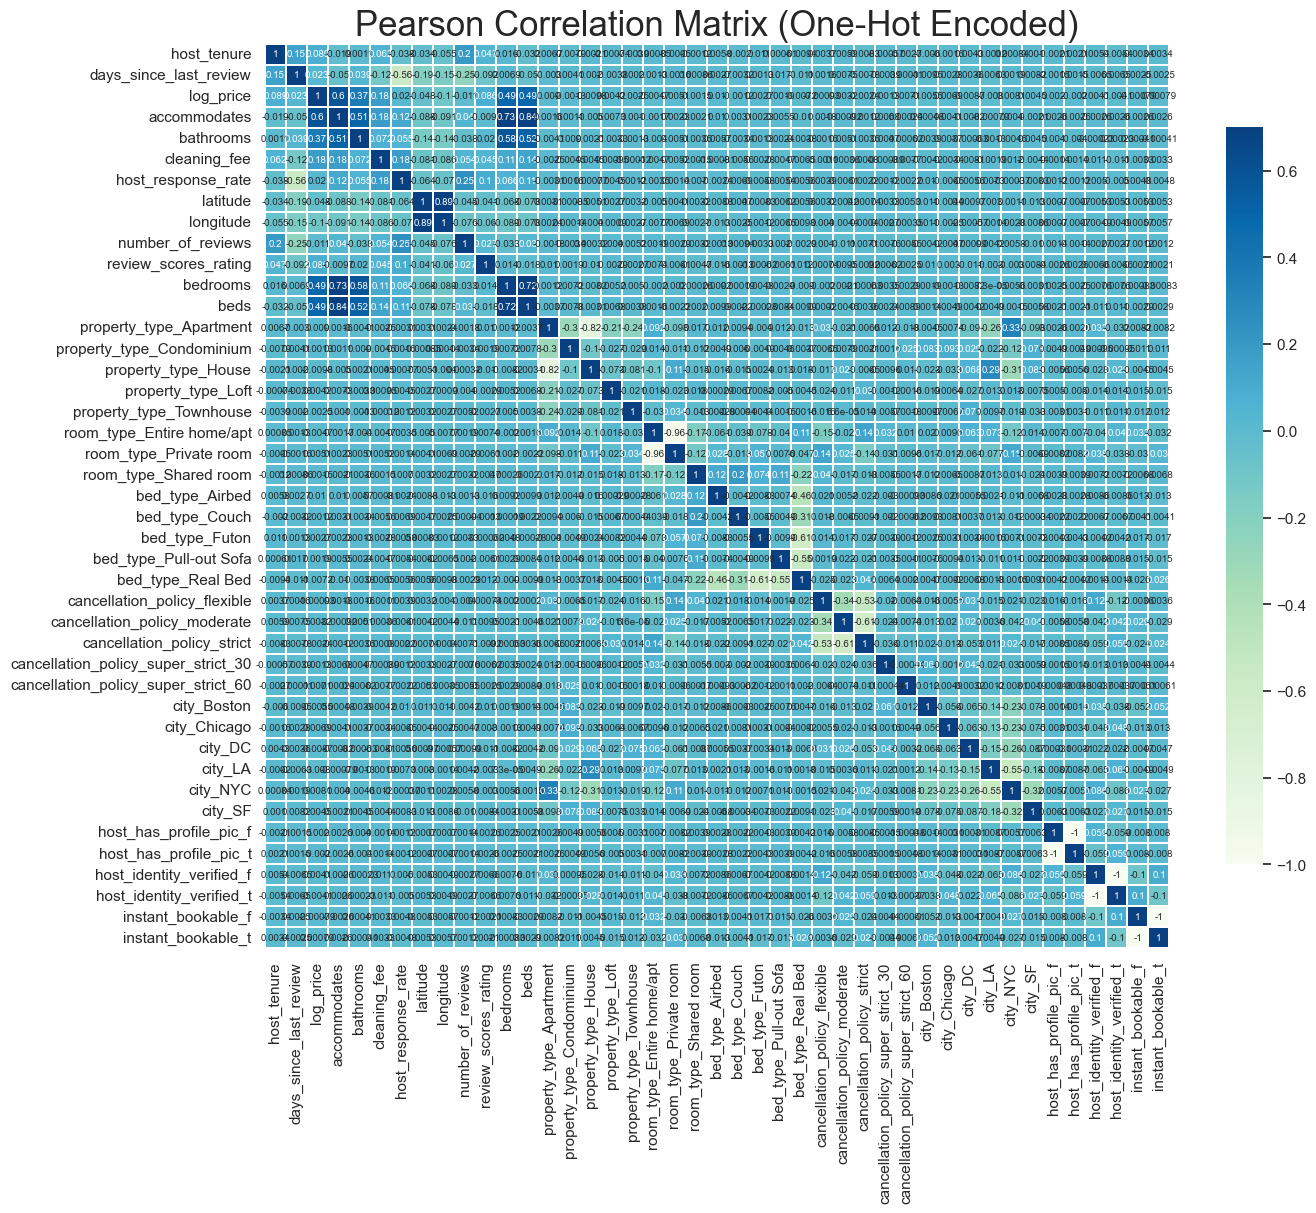

In [264]:
# performing one-hot-encoding
# Concatenate the one-hot encoded dataframe with the original dataframe
# Drop the original categorical columns (66748-15995 = 50753)
dfco = df.copy()
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(dfco[categorical_columns])
one_hot_dfco = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
dfco_encoded = pd.concat([dfco, one_hot_dfco], axis=1)
dfco_encoded = dfco_encoded.drop(categorical_columns, axis=1)
dfco = dfco_encoded[~pd.isnull(dfco_encoded)]
dfco.dropna()
print(dfco.head())

# print the pearson corr matrix
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix (One-Hot Encoded)',fontsize=25)
sns.heatmap(dfco.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":7}, cbar_kws={"shrink": .7})

# disadvantage becasue it adds on to more number of columns, hence interprating data becomes tougher and also the processing time increases

   host_tenure  days_since_last_review  log_price  property_type  room_type  \
0         4426                    2851   5.010635              0          0   
1         2515                    2419   5.129899              0          0   
2         2752                    2428   4.976734              0          0   
4         3356                    2663   4.744932              0          0   
5         2527                    2437   4.442651              0          1   

   accommodates  bathrooms  bed_type  cancellation_policy  cleaning_fee  ...  \
0             3        1.0         4                    2          True  ...   
1             7        1.0         4                    2          True  ...   
2             5        1.0         4                    1          True  ...   
4             2        1.0         4                    1          True  ...   
5             2        1.0         4                    2          True  ...   

   host_has_profile_pic  host_identity_verif

<Axes: title={'center': 'Pearson Correlation Matrix (Label Encoded)'}>

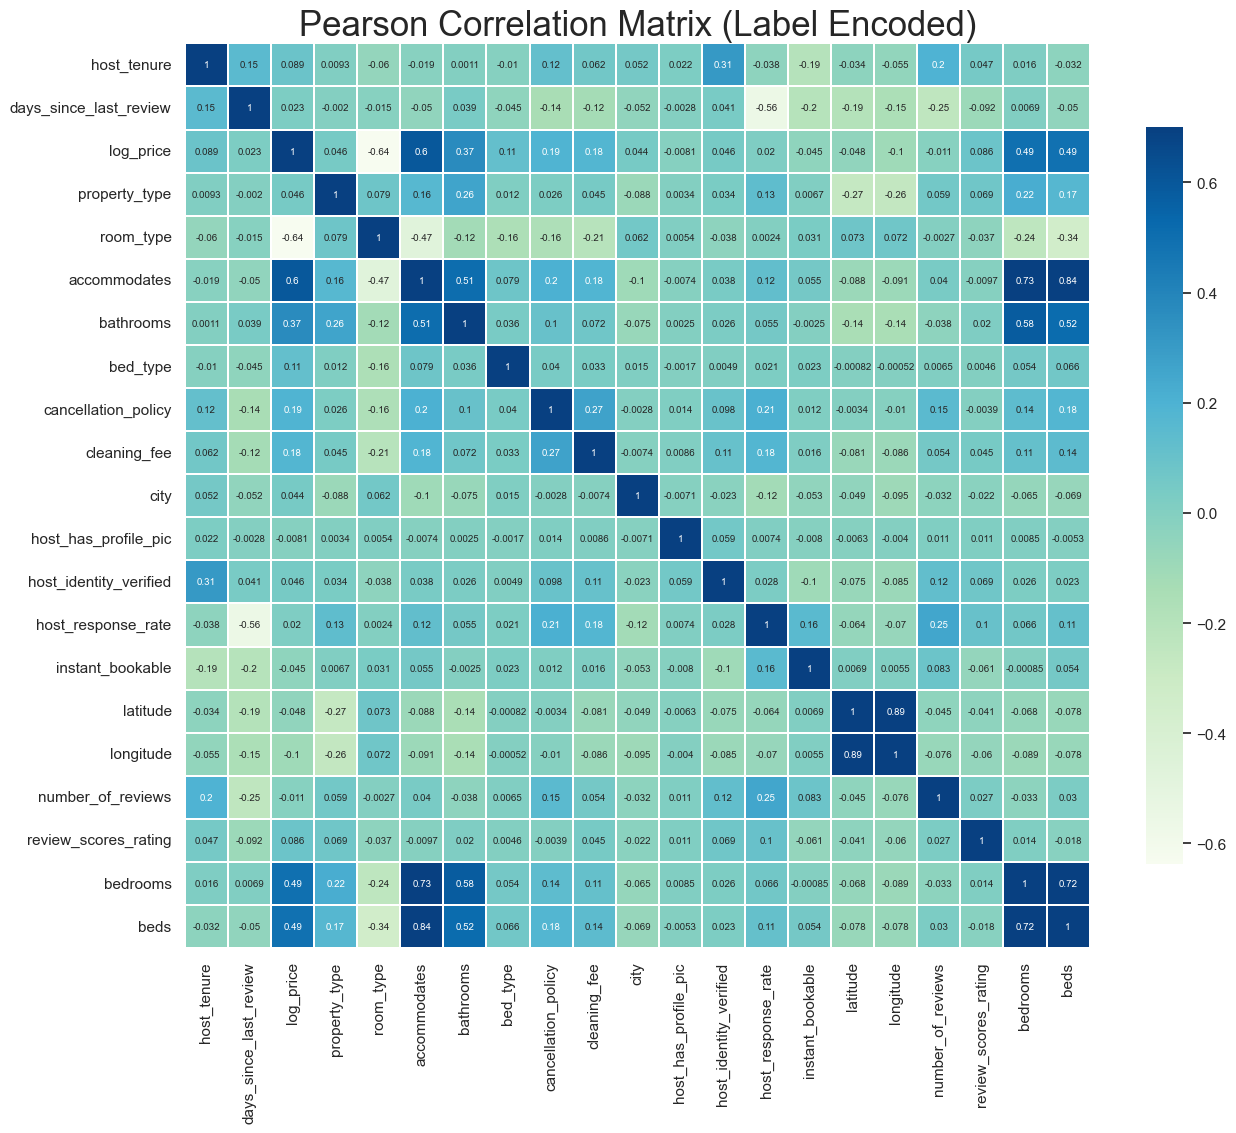

In [265]:
# performing label encoder
dfcl = df.copy()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_columns:
    dfcl[column] = label_encoder.fit_transform(dfcl[column])
print(dfcl.head())

# print the pearson corr matrix
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix (Label Encoded)',fontsize=25)
sns.heatmap(dfcl.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":7}, cbar_kws={"shrink": .7})

# better to understand and compartively less complex appearing than than the one hot encoded pearson matrix

# Exploratory Data Analysis (EDA):

## Task: Conduct a deep dive into the dataset to uncover underlying patterns and relationships. 
Analyze how pricing (`log_price`) correlates with both categorical (such as `room_type` and `property_type`) and numerical features (like `accommodates` and `number_of_reviews`). Utilize statistical tools and visualizations such as correlation matrices, histograms for distribution analysis, and scatter plots to explore relationships between variables.

In [266]:
print(df.isnull().sum())
print(df.info)

host_tenure               0
days_since_last_review    0
log_price                 0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
instant_bookable          0
latitude                  0
longitude                 0
number_of_reviews         0
review_scores_rating      0
bedrooms                  0
beds                      0
dtype: int64
<bound method DataFrame.info of        host_tenure  days_since_last_review  log_price property_type  \
0             4426                    2851   5.010635     Apartment   
1             2515                    2419   5.129899     Apartment   
2             2752                    2428   4.976734     Apartment   
4             3356                    2663   4.744932     Apartment   
5           

In [267]:
''' 
Univariate analysis:
Is used to explore each variable in a data set, separately. It looks at the range of values, as well as the central tendency of the values. It describes the pattern of response to the variable. It describes each variable on its own. Descriptive statistics describe and summarize data.
'''
# here done with Histograms
# based on city with property_type, room_type

plt.style.use('fivethirtyeight')
import matplotlib
font = {'family':'Georgia', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
df.columns

Index(['host_tenure', 'days_since_last_review', 'log_price', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'bedrooms', 'beds'],
      dtype='object')

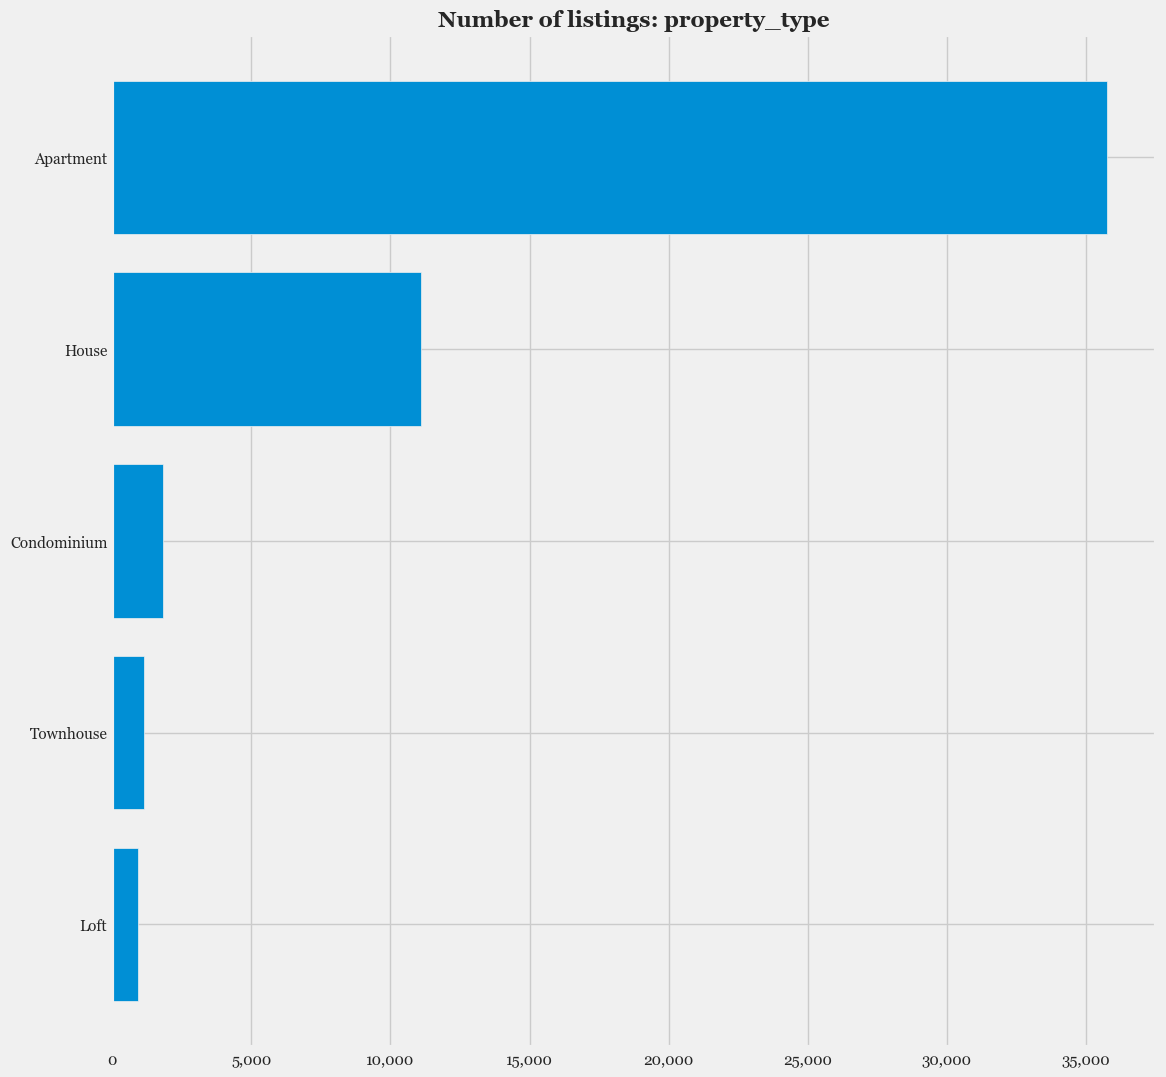

In [268]:
''' 
number of room listings preferences with the property_types which shows that nost preference goes to the apartment in majority of the cities with very very few importances given to exotic types i.e. near 0 preferences (not by mass number of people)
'''

dfp = df.groupby("property_type").count()["city"].reset_index().sort_values("city", ascending=False)
plt.figure(figsize=(12,12.5))
plt.barh(dfp["property_type"], dfp["city"])
ax = plt.gca()
ax.invert_yaxis()
plt.title("Number of listings: property_type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

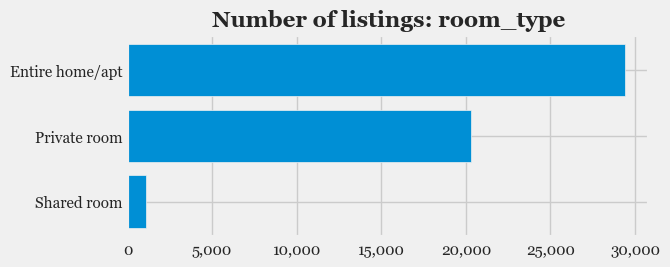

In [269]:
'''
number of room listings preferences with the room_types which shows that nost preference goes to the entire apartment in majority of the cities
'''
dfr = df.groupby("room_type").count()["city"].reset_index().sort_values("city", ascending=False)
plt.figure(figsize=(6,2.5))
plt.barh(dfr["room_type"], dfr["city"])
ax = plt.gca()
ax.invert_yaxis()
plt.title("Number of listings: room_type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [270]:
# Bivariate analysis: refers to the analysis of two variables to determine relationships between them.
''' 
here correlation with log_price is performed with:
# categorical features: 
    log_price & property_type
    log_price & room_type
    log_price & bed_type
    log_price & city
    log_price & neighbourhood -> removed

# numerical features:
    log_price & accomodates
    log_price & bathrooms
    log_price & number_of_reviews
    log_price & review_scores_rating
    log_price & bedrooms
    log_price & beds
    log_price & amenities -> removed

# host features:
    log_price & host_has_profile_pic
    log_price & host_identity_verified
    log_price & host_response_rate
    log_price & instant_bookable
    log_price & review_scores_rating

'''

' \nhere correlation with log_price is performed with:\n# categorical features: \n    log_price & property_type\n    log_price & room_type\n    log_price & bed_type\n    log_price & city\n    log_price & neighbourhood -> removed\n\n# numerical features:\n    log_price & accomodates\n    log_price & bathrooms\n    log_price & number_of_reviews\n    log_price & review_scores_rating\n    log_price & bedrooms\n    log_price & beds\n    log_price & amenities -> removed\n\n# host features:\n    log_price & host_has_profile_pic\n    log_price & host_identity_verified\n    log_price & host_response_rate\n    log_price & instant_bookable\n    log_price & review_scores_rating\n\n'

['Entire home/apt' 'Private room' 'Shared room']


Text(0.5, 0.98, 'Boxplot: Listing Price by property_type')

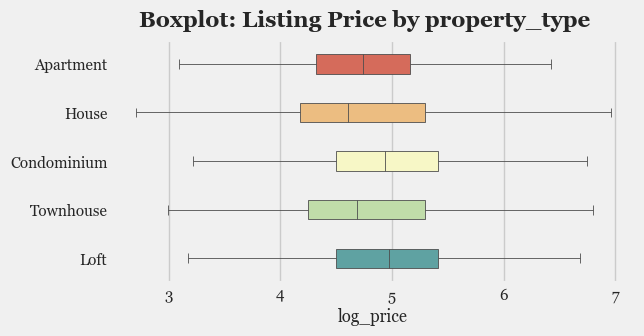

In [271]:
## categorical features:
    # log_price & property_type
    # log_price & room_type
    # log_price & bed_type
    # log_price & city
    # log_price & neighbourhood 

# correlation between log_price and property_type
'''
its observed that the log_price goes highest for the condominium and loft type house
Although the most of the people vote down to House type, thereby mainting the log_price not becoming too large value
the number of unique property_type was 1stfound out using df.unique() method 
'''
print(df['room_type'].unique())
plt.figure(figsize=(6, 3))
dft = df[['property_type', 'log_price']]
sns.boxplot(x='log_price', y='property_type', data=dft, order=['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by property_type', fontweight='bold', fontsize=16)

['Apartment' 'Condominium' 'House' 'Loft' 'Townhouse']


Text(0.5, 0.98, 'Boxplot: Listing Price by room_type')

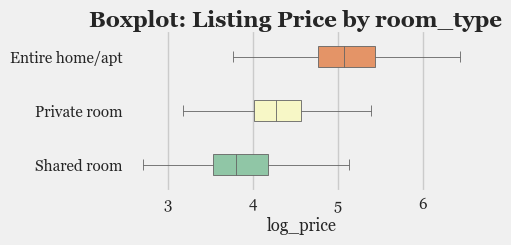

In [272]:
# correlation between log_price and room_type
''' 
lisiting log_price goes highest for the entire home/apt type meaning majority of the people are preferring this type and the category.
since the remaining 2 room types have values not intersecting the apt, room_type is a much greater contributor to the log_price prediciton
'''
print(df['property_type'].unique())
plt.figure(figsize=(4, 2))
dft = df[['room_type', 'log_price']]
sns.boxplot(x='log_price', y='room_type', data=dft, order=['Entire home/apt', 'Private room', 'Shared room'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by room_type', fontweight='bold', fontsize=16)

['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']


Text(0.5, 0.98, 'Boxplot: Listing Price by bed_type')

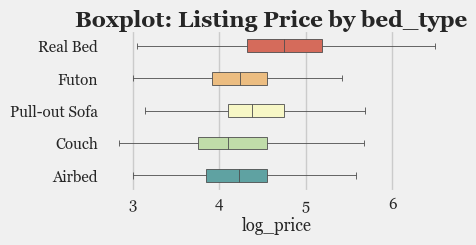

In [273]:
# correlation between log_price and bed_type
''' 
observing real bed goes high but greater variety is present with remaining categories being quite close enough, 
hence log_price value somewhat evenly spaced out for the remaining bed types, so can't expect much contribution from it.
'''
print(df['bed_type'].unique())
plt.figure(figsize=(4, 2))
dft = df[['bed_type', 'log_price']]
sns.boxplot(x='log_price', y='bed_type', data=dft, order=['Real Bed', 'Futon', 'Pull-out Sofa', 'Couch', 'Airbed'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by bed_type', fontweight='bold', fontsize=16)

['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']


Text(0.5, 0.98, 'Boxplot: Listing Price by city')

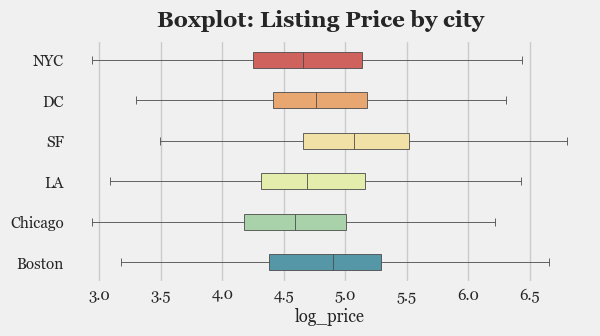

In [274]:
# moderate affects on the log_price
# correlation between log_price and city
print(df['city'].unique())
plt.figure(figsize=(6, 3))
dft = df[['city', 'log_price']]
sns.boxplot(x='log_price', y='city', data=dft, order=['NYC', 'DC', 'SF', 'LA', 'Chicago', 'Boston'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by city', fontweight="bold", fontsize=16)

In [275]:
# # correlation between log_price and neighbourhood
# print(df['neighbourhood'].unique())
# # too many differnet neighbourhoods, hence not much insightful about the tendency of the host to reside can be concluded from here

In [276]:
new_df = pd.DataFrame(dfcl.corr(method="pearson")["log_price"])
new_df.reset_index(inplace=True)
new_df.columns = ["features", "correlation_with_price"]
new_df.sort_values("correlation_with_price", ascending=False)
df1 = new_df[new_df["correlation_with_price"] > 0.1]
corr_features = df1["features"].values
corr_features.tolist().append("log_price")
df1.drop([2], inplace=True)
df1

features  correlation_with_price
5          accommodates                0.596466
6             bathrooms                0.368188
7              bed_type                0.114874
8   cancellation_policy                0.191205
9          cleaning_fee                0.179416
19             bedrooms                0.492308
20                 beds                0.489918

Text(0.5, 0.98, 'Number of people accomodated  [Correlation: 0.596]')

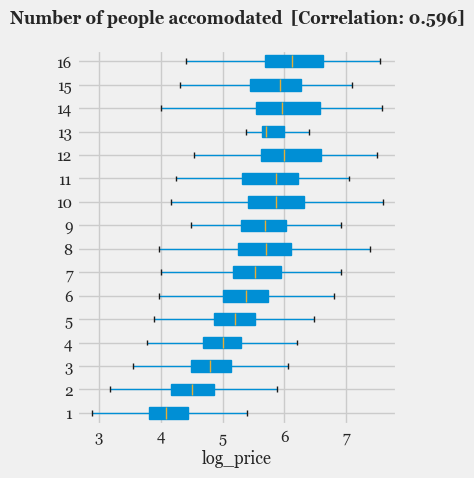

In [277]:
## numerical features:
    # log_price & accomodates
    # log_price & bathrooms
    # log_price & number_of_reviews
    # log_price & review_scores_rating
    # log_price & bedrooms
    # log_price & beds
    # log_price & amenities -> ***need to figure out***

# for correlation between log_price and no. of people accomodated
# correlation with log_price is >0.5 hence moderate contribution by number of people accomodated i.e. it shows positive correlation
''' 
A positive correlation indicates that there is a direct relationship between two variables, with both variables moving in the same direction (e.g., when one variable increases, the other does as well).
'''
col = 'accommodates'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of people accomodated  [Correlation: " + str(cov) + "]"
plt_name = "accommodates"

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Number of Bathrooms  [Correlation: 0.368]')

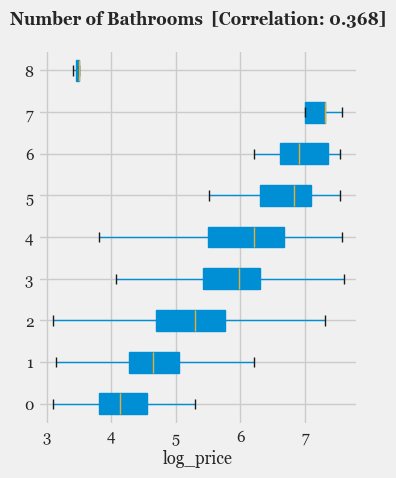

In [278]:
# for correlation between log_price and no. of bathrooms
# correlation with the log_price is <0.4, hence no. of bathrooms not much deciding factor
col = 'bathrooms'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of Bathrooms  [Correlation: " + str(cov) + "]"
plt_name = 'bathrooms'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

In [279]:
# for correlation between log_price and no. of people accomodated
print(df['number_of_reviews'].unique())
print(df['review_scores_rating'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot

[  2   6  10   4   3   9 159  82  29  13  15  12  26   5  57  73  14  40
   1 248  17 138  11  44  34  85  18  31  30  19  25  22  23  28   7  32
 144  16  38 105  59  67  21  61  87 206   8  43 104  47 186  36  27 167
  48 102  51 126  81  72  58  79  63  78  55  54  52  42  75 128  60  90
 254 135  64 191  24  66 139 125 129  74 318  33 187  35  37  20  70  39
  46  83  45  41  49 289 190  62  88 127 154 118 136  69 314 112  77  56
 181  99  53 117 101 106 255 114 110 192  76 113  91 123  84 146 119  86
  50  71 157  95 158 142  97 194 173 122 132 171  68 111 161 208 131 384
 216 133 116 148  89 156 179 147 145 202 150 258 120  98 178 200 155 163
 149 107  94 267 100  65 207 172 121 180  80  92 263 193 251 199 103 166
 237 290 137 153  96 425 185 140 168 162  93 360 141 246 195 196 109 273
 305 214 351 152 189 269 134 221 317 218 217 336 272 175 143 215 188 278
 383 160 203 165 115 108 256 198 323 465 302 469 220 204 170 182 480 287
 225 492 224 201 288 389 343 303 169 228 236 205 28

Text(0.5, 0, 'log_price')

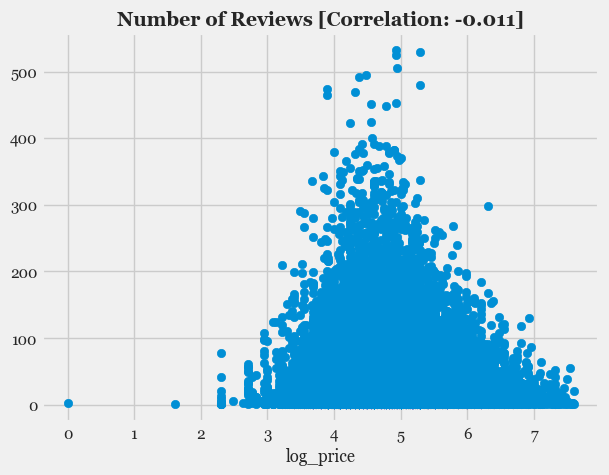

In [280]:
# for correlation between log_price and number_of_reviews
''' 
A negative correlation is a relationship between two variables that move in opposite directions. In other words, when variable A increases, variable B decreases. A negative correlation is also known as an inverse correlation. Two variables can have varying strengths of negative correlation.
'''
# no. of reviews is almost moving alongside the log_price values.
# since ~ 0, hence we can say that there is hardly any correlation of review no. with the log_price
col = 'number_of_reviews'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Number of Reviews [Correlation: " + str(cov) + "]"
plt_name = 'number_of_reviews'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

Text(0.5, 0, 'log_price')

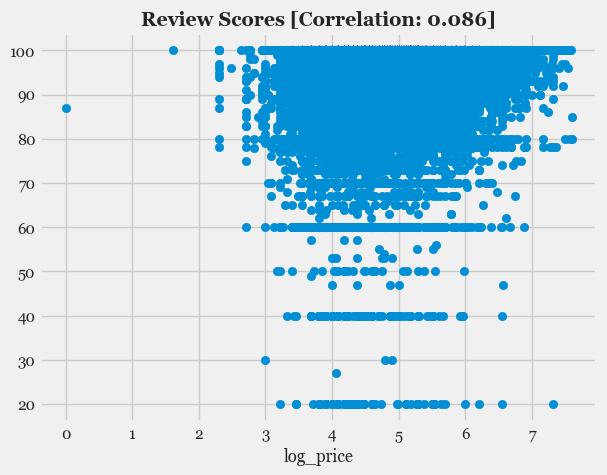

In [281]:
# for correlation between log_price and review_scores_rating
# nearing a no relationship status with the log_price i.e.
''' 
A zero correlation suggests that the correlation statistic does not indicate a relationship between the two variables. This does not mean that there is no relationship at all; it simply means that there is not a linear relationship. A zero correlation is often indicated using the abbreviation r = 0
'''
col = 'review_scores_rating'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Review Scores [Correlation: " + str(cov) + "]"
plt_name = 'review_scores_rating'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

Text(0.5, 0.98, 'Number of Bedrooms  [Correlation: 0.492]')

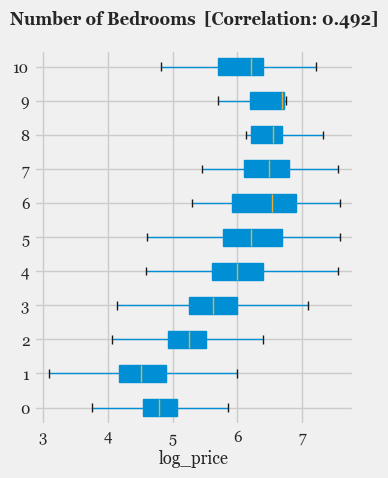

In [282]:
# for correlation between log_price and no. of bedrooms
# no. of bedrooms have moderate impact on log_price value showing a positive correlation
col = 'bedrooms'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of Bedrooms  [Correlation: " + str(cov) + "]"
plt_name = 'bedrooms'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Beds [Correlation: 0.49]')

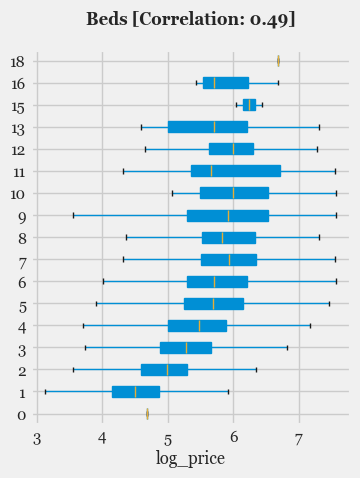

In [283]:
# for correlation between log_price and no. of beds
# moderate positive correlation with log_price by beds
col = 'beds'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Beds [Correlation: " + str(cov) + "]"
plt_name = 'beds'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Has Profile Pic  [Correlation: -0.008]')

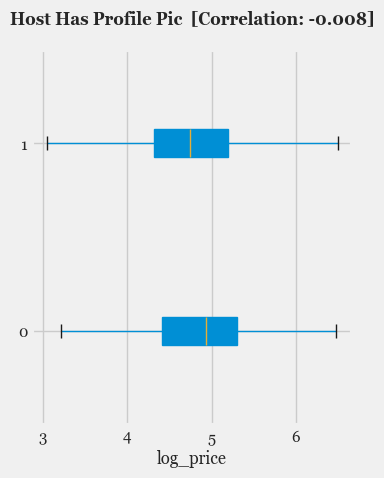

In [284]:
# host features:
    # log_price & host_has_profile_pic
    # log_price & host_identity_verified
    # log_price & host_response_rate
    # log_price & instant_bookable
# 
# for correlation between log_price and host_has_profile_pic
# near zero correlation hence not a great affecting factor
col = 'host_has_profile_pic'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Has Profile Pic  [Correlation: " + str(cov) + "]"
plt_name = 'host_has_profile_pic'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Identity Verified  [Correlation: 0.046]')

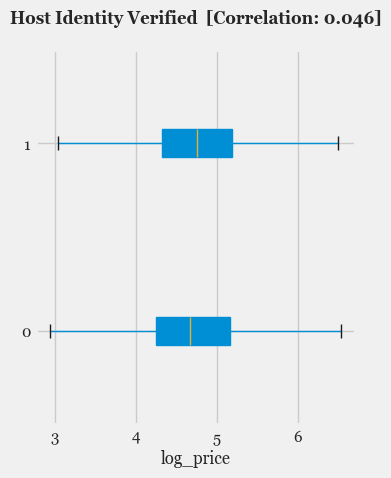

In [285]:
# for correlation between log_price and host_identity_verified
# near zero correlation hence not a great affecting factor
# standstill type relation with the log_price
col = 'host_identity_verified'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Identity Verified  [Correlation: " + str(cov) + "]"
plt_name = 'host_identity_verified'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Instant Bookable  [Correlation: -0.045]')

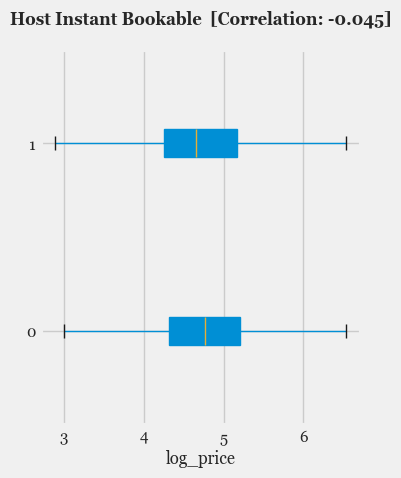

In [286]:
# for correlation between log_price and instant_bookable
# negatively near zero correlation i.e mif bookings increase then the log_price decreases as its tending to the inverse relation
col = 'instant_bookable'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Instant Bookable  [Correlation: " + str(cov) + "]"
plt_name = 'instant_bookable'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

[  0 100  71  68  67  90  86  92  82  80  89  93  99  50  70  91  25  96
  95  98  62  88  29  81  63  38  60  79  75  65  94  97  87  40  33  58
  76  83  30  64  17  20  77  53  78  54  73  41  57  85  56  42  44  14
  10  72  84  55  43  74  36  39  46  26  61  59  52  22  15  69  27  11
  35  31  21  47  66]


Text(0.5, 0, 'log_price')

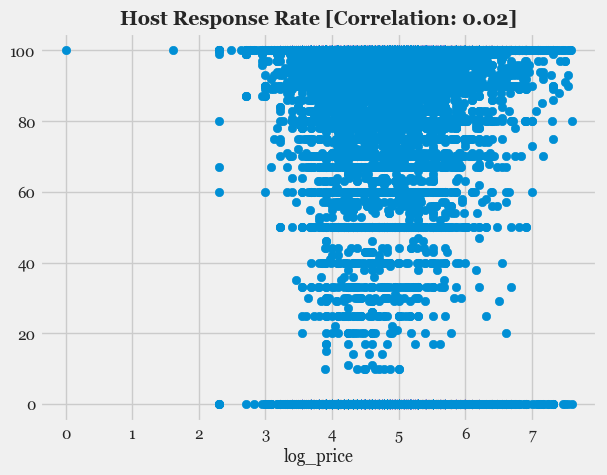

In [287]:
# for correlation between log_price and instant_bookable
print(df['host_response_rate'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot
col = 'host_response_rate'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Host Response Rate [Correlation: " + str(cov) + "]"
plt_name = 'host_response_rate'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

## considerable hosts have response rate of 100% between the log_prices of 3 and 6

[100.          93.          92.          40.          99.
  97.          89.          91.          88.          86.
  72.          98.          96.          84.          95.
  78.09772821  94.          80.          87.          85.
  90.          70.          20.          76.          60.
  83.          82.          75.          73.          55.
  67.          71.          77.          79.          78.
  81.          47.          74.          68.          50.
  65.          53.          64.          69.          66.
  27.          62.          49.          57.          54.
  63.          30.          56.        ]


Text(0.5, 0, 'log_price')

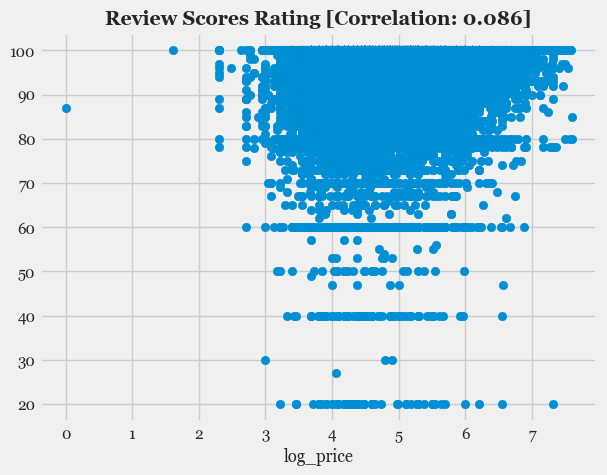

In [288]:
# for correlation between log_price and review_scores_rating
print(df['review_scores_rating'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot
col = 'review_scores_rating'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Review Scores Rating [Correlation: " + str(cov) + "]"
plt_name = 'review_scores_rating'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

## heavily clustered review scores between log_price of 3 and 6
## within this range, the ratings scores are also quite high, meaning likely responsable

In [289]:
# other possible interesting comparisons:
# city/ neighbourhood & review_scores_rating
dft_c = df[["city", "review_scores_rating"]].copy()
dft_c.groupby("city").mean().reset_index().sort_values("review_scores_rating", ascending=False)

city  review_scores_rating
1  Chicago             95.185901
5       SF             94.925386
2       DC             94.607195
3       LA             94.206997
0   Boston             93.453888
4      NYC             93.257999

# Geospatial Analysis:
## Task: Investigate the geographical data to understand regional pricing trends. 
Plot listings on a map using `latitude` and `longitude` data to visually assess price distribution. Examine if certain neighbourhoods or proximity to city centres influence pricing, providing a spatial perspective to the pricing strategy.

****(incomplete and only tried this much)****

<Axes: xlabel='longitude', ylabel='latitude'>

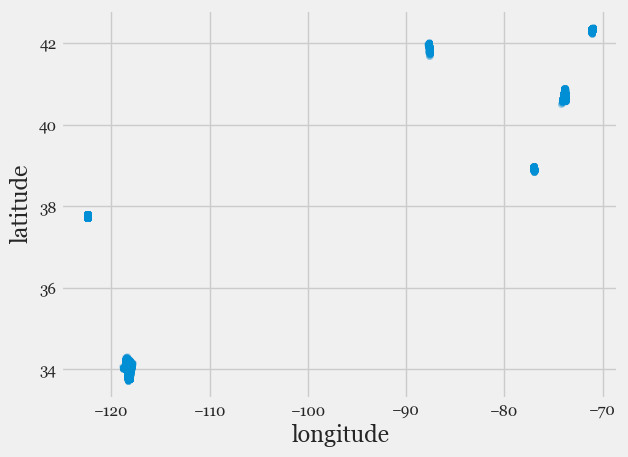

In [290]:
dfcl.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
# from the plot we observe that the places are quite nearby and heavily concentrated only in 6 regions approx
# possible location 1 (RHS most point): 40°41'47.5"N 73°59'29.8"W = NEW YORK
# possible location 2 (LHS most point): 33°59'39.6"N 118°28'23.2"W = LOS ANGELES
# hence consider Cartographic Boundary Files of USA

<Axes: xlabel='longitude', ylabel='latitude'>

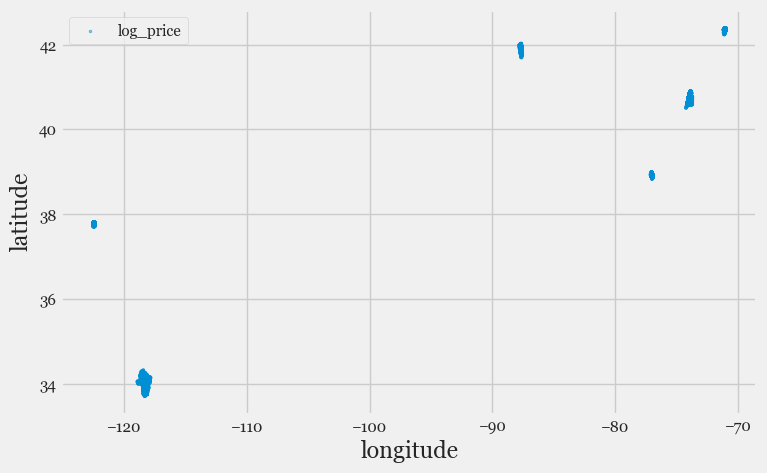

In [291]:
# to understand the effect of log_price with the location coordinates:
dfcl.plot(kind="scatter", x="longitude", y="latitude", s=dfcl['log_price'], cmap=plt.get_cmap("jet"), label='log_price', alpha=0.5, figsize=(8,5))

<Axes: >

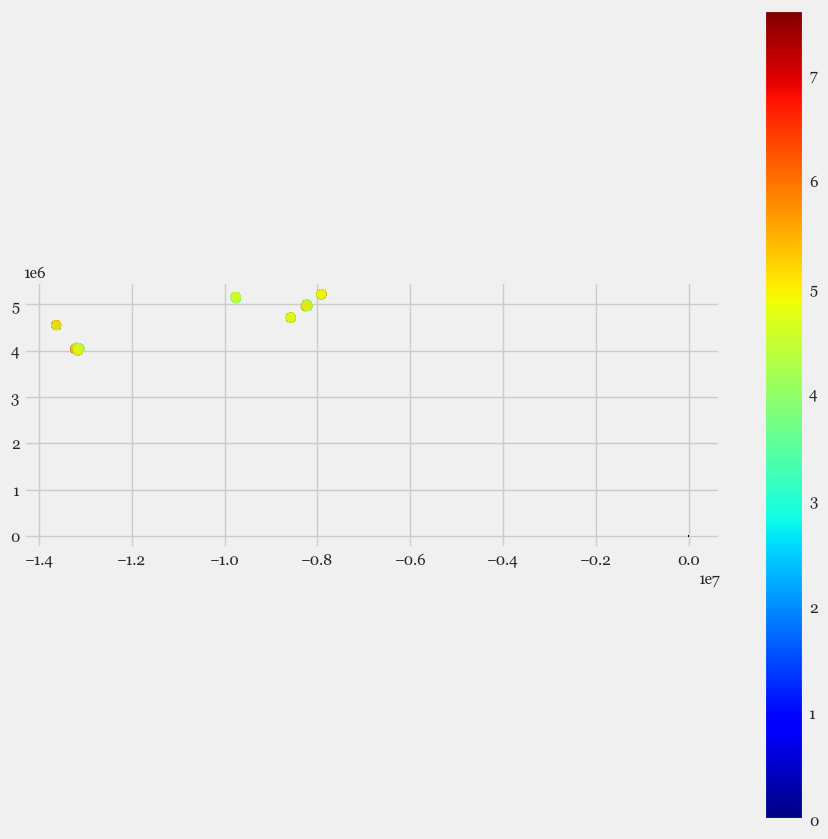

In [292]:
''' 
Side notes on EPSG & CRS:
4326 - latitude/longitude coordinate system based on the Earth's center of mass, used by GPS
3857 - Web Mercator projection used for display by many web-based mapping tools
'''

# packages for geospatial plotting & analysis
import geopandas as gpd
import folium
df_geo = gpd.GeoDataFrame(dfcl.copy(), geometry=gpd.points_from_xy(dfcl["longitude"], dfcl["latitude"]))
df_geo.crs = {"init": "epsg:4326"}

regions = gpd.read_file('cb_2018_us_county_within_cd116_500k/cb_2018_us_county_within_cd116_500k.shp')

ax = regions.plot(figsize=(10,10), color="whitesmoke", linestyle=":", edgecolor="black")

df_geo.to_crs(epsg=3857).plot(column='log_price', alpha=0.5, ax=ax, c='log_price', cmap=plt.get_cmap("jet"), legend=True)

# Sentiment Analysis on Textual Data:
## Task: Apply advanced natural language processing techniques to the `description` texts to extract sentiment scores. 
Use sentiment analysis tools to determine whether positive or negative descriptions influence listing prices, incorporating these findings into the predictive model being trained as a feature.


In [293]:
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

df_copy['description']

0        Beautiful, sunlit brownstone 1-bedroom in the ...
1        Enjoy travelling during your stay in Manhattan...
2        The Oasis comes complete with a full backyard ...
4        Cool, cozy, and comfortable studio located in ...
5        Beautiful private room overlooking scenic view...
                               ...                        
74097    Enjoy a stay in my beautiful, well-furnished d...
74100    This apartment fosters mid-century modernism s...
74103    CENTRALLY LOCATED Studio Unit in the WorldMark...
74107    Located on the Pacific Coast Highway, this apa...
74108    A modern apartment located in East Williamsbur...
Name: description, Length: 50753, dtype: object

In [294]:
''' 
Structuring the data (Sentiment Analysis)

Next step would be to work with the TextBlob library. TextBlob is a python library for Natural Language Processing (NLP). TextBlob is a simple library which supports complex analysis and operations on textual data. TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. Negation words reverse the polarity. TextBlob has semantic labels that help with fine-grained analysis. For example — emoticons, exclamation mark, emojis, etc. Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. TextBlob has one more parameter — intensity. TextBlob calculates subjectivity by looking at the ‘intensity’. Intensity determines if a word modifies the next word. For English, adverbs are used as modifiers (‘very good’).
'''
df_copy.insert(0, 'sentiment', 0)
df_copy['sentiment'] = df_copy['description'].apply(lambda x: (TextBlob(x).sentiment.polarity))
df_copy.head()

sentiment  host_tenure  days_since_last_review  log_price property_type  \
0   0.716667         4426                    2851   5.010635     Apartment   
1   0.250000         2515                    2419   5.129899     Apartment   
2   0.274085         2752                    2428   4.976734     Apartment   
4   0.196795         3356                    2663   4.744932     Apartment   
5   0.292143         2527                    2437   4.442651     Apartment   

         room_type                                          amenities  \
0  Entire home/apt  {"Wireless Internet","Air conditioning",Kitche...   
1  Entire home/apt  {"Wireless Internet","Air conditioning",Kitche...   
2  Entire home/apt  {TV,"Cable TV","Wireless Internet","Air condit...   
4  Entire home/apt  {TV,Internet,"Wireless Internet","Air conditio...   
5     Private room  {TV,"Wireless Internet",Heating,"Smoke detecto...   

   accommodates  bathrooms  bed_type  ... host_since  instant_bookable  \
0             3        1.0  Real Bed  ... 2012-03-26                 f   
1             7        1.0  Real Bed  ... 2017-06-19                 t   
2             5        1.0  Real Bed  ... 2016-10-25                 t   
4             2        1.0  Real Bed  ... 2015-03-01                 t   
5             2        1.0  Real Bed  ... 2017-06-07                 t   

  last_review   latitude   longitude     neighbourhood number_of_reviews  \
0  2016-07-18  40.696524  -73.991617  Brooklyn Heights                 2   
1  2017-09-23  40.766115  -73.989040    Hell's Kitchen                 6   
2  2017-09-14  40.808110  -73.943756            Harlem                10   
4  2017-01-22  38.925627  -77.034596  Columbia Heights                 4   
5  2017-09-05  37.753164 -122.429526        Noe Valley                 3   

   review_scores_rating bedrooms beds  
0                 100.0      1.0  1.0  
1                  93.0      3.0  3.0  
2                  92.0      1.0  3.0  
4                  40.0      0.0  1.0  
5                 100.0      1.0  1.0  

[5 rows x 28 columns]

In [295]:
''' 
Categorize the values into 'positive' or 'negative' in order to run it through our classfication algorithm. Created a function called polarity_to_Sentiment to categorize the values based on a range (-1 to 1). Between -1 and < 0, negative. 0, neutral. Between > 0 and 1, positive.
'''
def polarity_to_sentiment(x):
    if (x >= -1  and x < 0):
        return 'negative'
    if (x == 0):
        return 'neutral'
    if (x > 0 and x<=1):
        return 'positive'
    
# applying polarity_to_Sentiment function to 'sentiment' column
df_copy.sentiment = df_copy.sentiment.apply(polarity_to_sentiment)
df_copy['sentiment']

0        positive
1        positive
2        positive
4        positive
5        positive
           ...   
74097    positive
74100    positive
74103    positive
74107    positive
74108    positive
Name: sentiment, Length: 50753, dtype: object

In [296]:
# data exploration
# viewing the number of times each category appears in the 'sentiment' column
df_copy['sentiment'].value_counts()

sentiment
positive    50060
neutral       375
negative      318
Name: count, dtype: int64

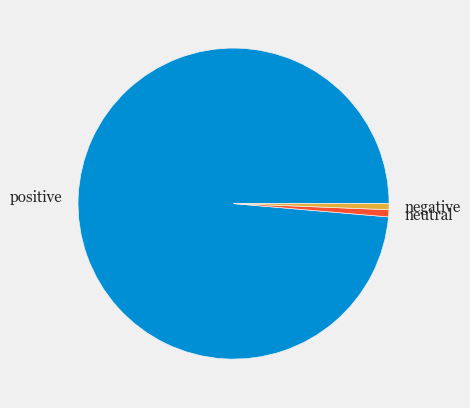

In [297]:
#Creating a pie chart
a = np.array([50060, 375, 318])
mylabels = ['positive', 'neutral', 'negative']

plt.pie(a, labels = mylabels)
plt.show()

(-0.5, 799.5, 599.5, -0.5)

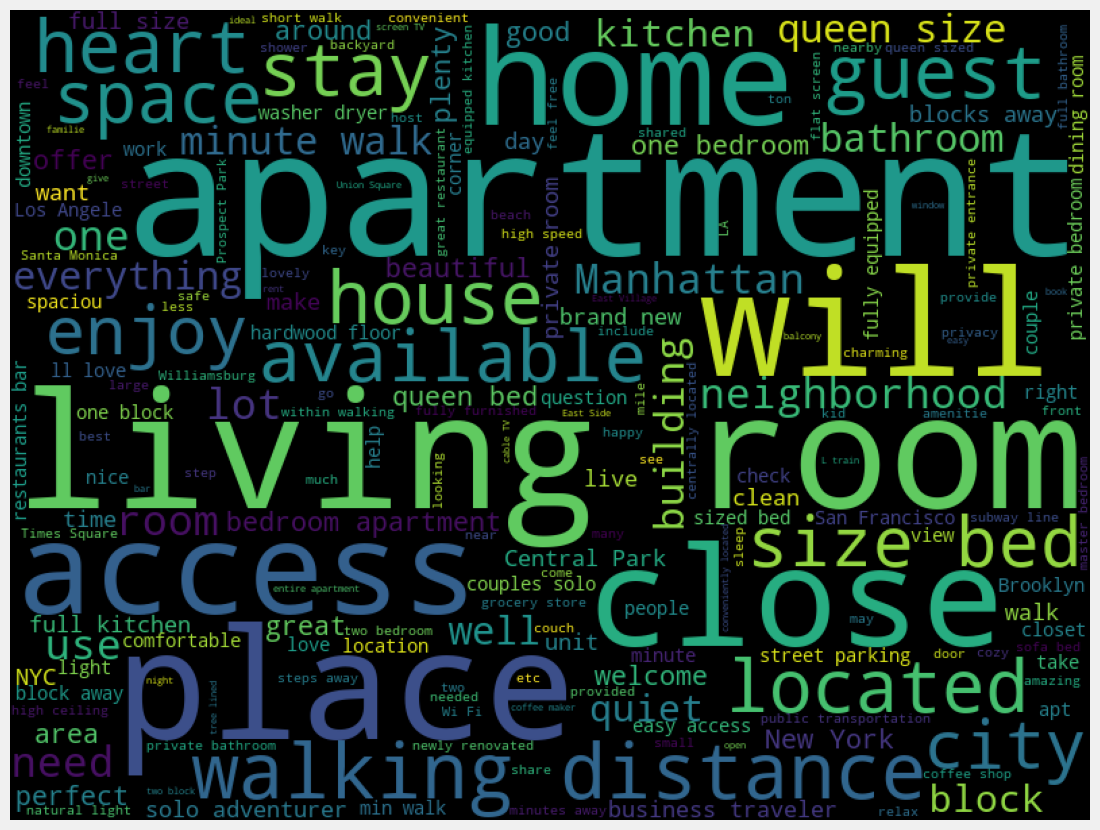

In [298]:
''' 
We have about 98.6% percent of reviews as positive, about 0.63% percent of reviews as negative and about 0.77% of reviews as neutral, we can see there is a clear imbalance in the label, as we have positive sentiment accounting for almost all the observations, So created a wordcloud visualization of each sentiment category, to see what words appear the most and least per category.
'''

# creating positive sentiment category
positive_sentiment = df_copy['sentiment'] == 'positive'

# creating a word cloud visualization of the Positive sentiment category
cloud = WordCloud(width=800, height=600).generate(" ".join(df_copy[positive_sentiment]['description'])) 
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')


(-0.5, 799.5, 599.5, -0.5)

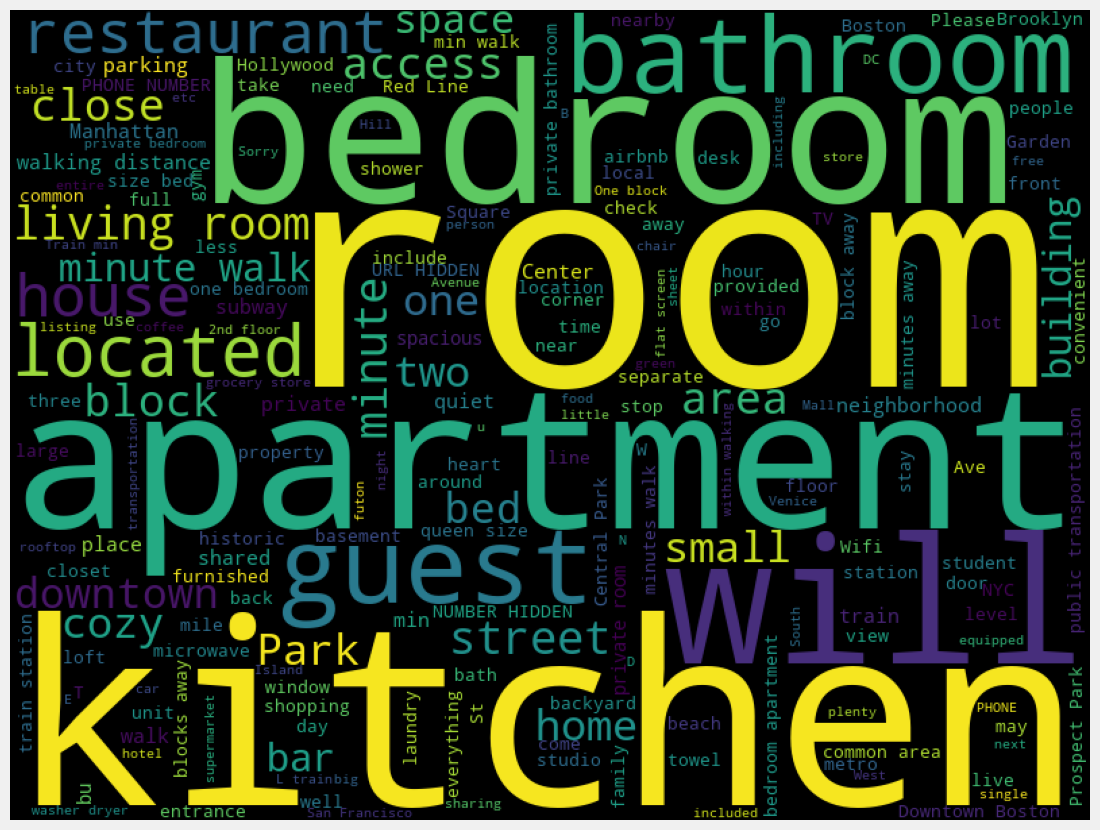

In [299]:
# creating negative sentiment category
negative_sentiment = df_copy['sentiment'] == 'negative'

# creating a word cloud visualization of the negative sentiment category
cloud = WordCloud(width=800, height=600).generate(" ".join(df_copy[negative_sentiment]['description'])) 
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

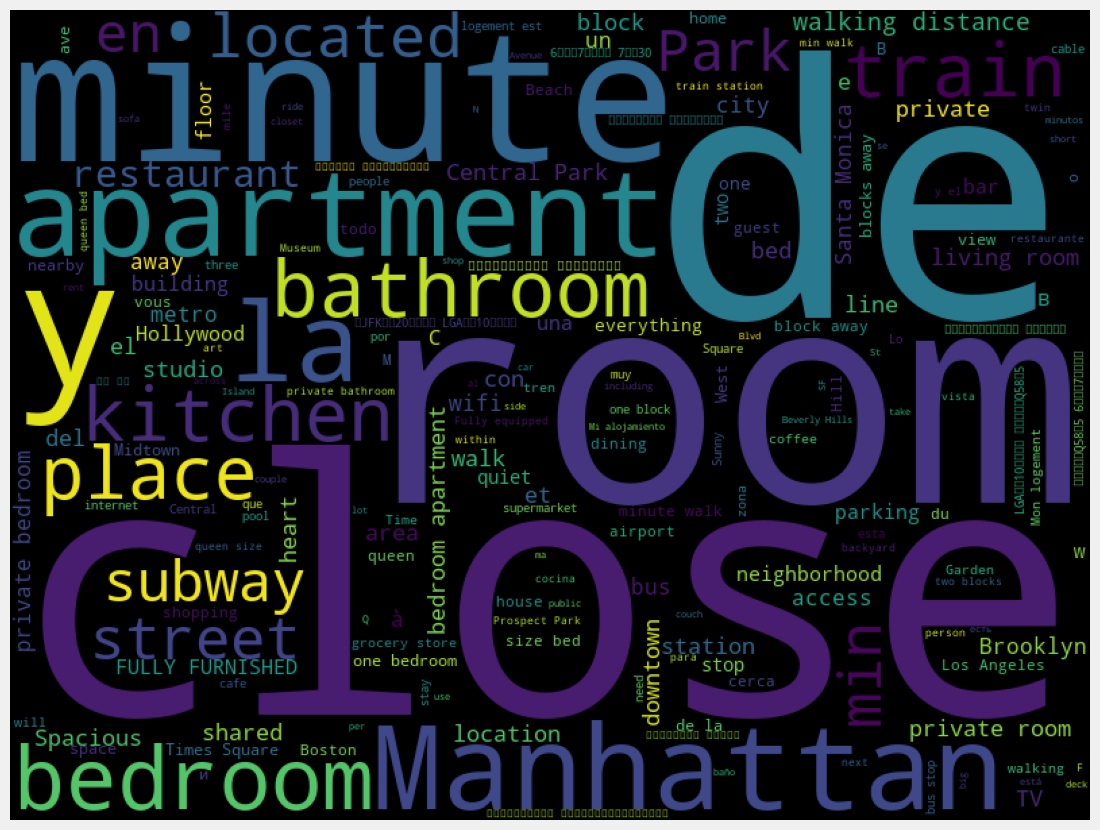

In [300]:
# creating neutral sentiment category
neutral_sentiment = df_copy['sentiment'] == 'neutral'

# creating a word cloud visualization of the neutral sentiment category
cloud = WordCloud(width=800, height=600).generate(" ".join(df_copy[neutral_sentiment]['description'])) 
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

In [301]:
# feature selection
x = df_copy['description']
y = df_copy['sentiment']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 4)


# fitting our training data (x_train) into TfidfVectorizer() and return the matrix. Then transform our testing data (x_test) and return the matrix.
from sklearn.feature_extraction.text import TfidfVectorizer

#Instantiating TfidfVectorizer method
tfidf_vector = TfidfVectorizer(ngram_range=(1,1), lowercase = True, stop_words= 'english')

#fitting our training data (x_train) into TfidfVectorizer() and returning the matrix
x_train = tfidf_vector.fit_transform(x_train)

#transforming our testing data (x_test) and returning the matrix
x_test  = tfidf_vector.transform(x_test)

In [302]:
''' 
Training

Here the Balanced Bagging Classifier is used to train our model. When we try to use a usual classifier to classify an imbalanced dataset, the model favors the majority class due to its larger volume presence. A Balanced Bagging Classifier is the same as a sklearn classifier but with additional balancing. It includes an additional step to balance the training set at the time of fit for a given sampler. This classifier takes two special parameters “sampling_strategy” and “replacement”. The sampling_strategy decides the type of resampling required (e.g. ‘majority’ – resample only the majority class, ‘all’ – resample all classes, etc) and replacement decides whether it is going to be a sample with replacement or not.
'''

#Importing Balanced Bagging Algorithm
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# here we dont want to oversample minorty class and match the majority class because the negative and neutral reviews are way to less in comparison to positive ones
classif = BalancedBaggingClassifier(sampling_strategy='not majority', replacement=False, random_state=42)
classif.fit(x_train, y_train)

BalancedBaggingClassifier(random_state=42, sampling_strategy='not majority')

In [303]:
# predicted values
y_hat = classif.predict(x_test)

# evaluation
''' 
added an 'average = 'weighted'' parameter as opposed to not adding anything because we are dealing with a multiclass classification task and not binary classification. By default 'average = 'binary'' if nothing is added. 'average' can also be 'micro’, ‘macro’, ‘samples’.
'''

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('accuracy score: ', accuracy_score(y_hat, y_test), '\n')
print('precision_score: ', precision_score(y_hat, y_test, average='weighted'), '\n')
print('recall score: ', recall_score(y_hat, y_test, average='weighted'), '\n')
print('f1 score: ', f1_score(y_hat, y_test, average='weighted'), '\n')

accuracy score:  0.9855510311309602 

precision_score:  0.9897612752628219 

recall score:  0.9855510311309602 

f1 score:  0.9876080078047302 



In [304]:
''' 
To see how the true Label values from the dataframe (y) compare to our predicted values from the dataframe (y_hat) based on the features from the dataframe (Displaying 3 rows)
'''
for i in range (3):
    print(y[i], y_hat[i])

positive positive
positive positive
positive positive


# Model Development and Training:
## Task: Design and train predictive models to estimate `log_price`. 
Begin with a simple linear regression to establish a baseline, then explore more complex models such as RandomForest and GradientBoosting to 
better capture non-linear relationships and interactions between features. Document (briefly within Jupyter notebook itself) the model-building process, specifying the choice of algorithms and rationale.

# Model Optimization and Validation:
## Task: Systematically optimize the models to achieve the best performance.
Employ techniques like grid search to experiment with different hyperparameters settings. Validate model choices through techniques 
like k-fold cross-validation, ensuring the model generalizes well to unseen data.

# Feature Importance and Model Insights:
## Task: Analyze the trained models to identify which features most significantly impact `log_price`. 
Utilize model-specific methods like feature importance scores for tree-based models and SHAP values for an in-depth understanding of feature contributions.

<Axes: >

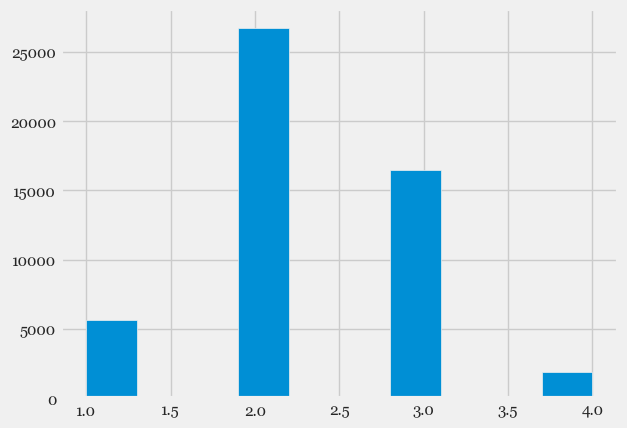

In [305]:
''' 
utilizing the pipeline because:
Pipelining enables a table function to return rows faster and can reduce the memory required to cache a table function's results. A pipelined table function can return the table function's result collection in subsets. The returned collection behaves like a stream that can be fetched from on demand.
'''
# Combined pipeline for both numerical and categorical features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Pipeline for numerical features
# Select numerical columns only
numerical_attribs = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'host_response_rate']
numerical_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# Pipeline for categorical features
categorical_attribs = ['property_type', 'room_type', 'bed_type', 'city']
categorical_pipeline = Pipeline([
        ('ordinal_encoder', OrdinalEncoder()),
    ])
# Combined Pipeline for all features
preprocessing_pipeline = ColumnTransformer([
        ("categorical", categorical_pipeline, categorical_attribs),
        ("numerical", numerical_pipeline, numerical_attribs),
    ])

label = ['log_price']
df_attribs = dfcl[categorical_attribs + numerical_attribs + label].copy()
df_prepared = preprocessing_pipeline.fit_transform(dfcl[categorical_attribs + numerical_attribs])

# log_price categories
df_attribs['log_price_label'] = pd.cut(df['log_price'], bins=[0, 4, 5, 6, np.inf], labels=[1, 2, 3, 4])

# Distribution of class labels in overall dataset
df_attribs['log_price_label'].hist()


In [306]:
df_attribs[df_attribs['log_price_label'].isna()]
df_attribs = df_attribs.dropna()
df_attribs.isnull().sum()

property_type           0
room_type               0
bed_type                0
city                    0
accommodates            0
bathrooms               0
number_of_reviews       0
review_scores_rating    0
bedrooms                0
beds                    0
host_response_rate      0
log_price               0
log_price_label         0
dtype: int64

In [307]:
# Split Dataset into train and test sets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
df_attribs.reset_index(inplace=True)
del df_attribs['index']

# since the data is significantly large and unbalanced, stratified sampling is performed as also can be seen fron the scatterplot later on
# this ensure that the training and test datasets have the same proportion of class labels as the input dataset.
# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df_attribs, df_attribs['log_price_label']):
    strat_train_set = df_attribs.loc[train_index]
    strat_test_set = df_attribs.loc[test_index]

array([[<Axes: xlabel='review_scores_rating', ylabel='review_scores_rating'>,
        <Axes: xlabel='log_price', ylabel='review_scores_rating'>],
       [<Axes: xlabel='review_scores_rating', ylabel='log_price'>,
        <Axes: xlabel='log_price', ylabel='log_price'>]], dtype=object)

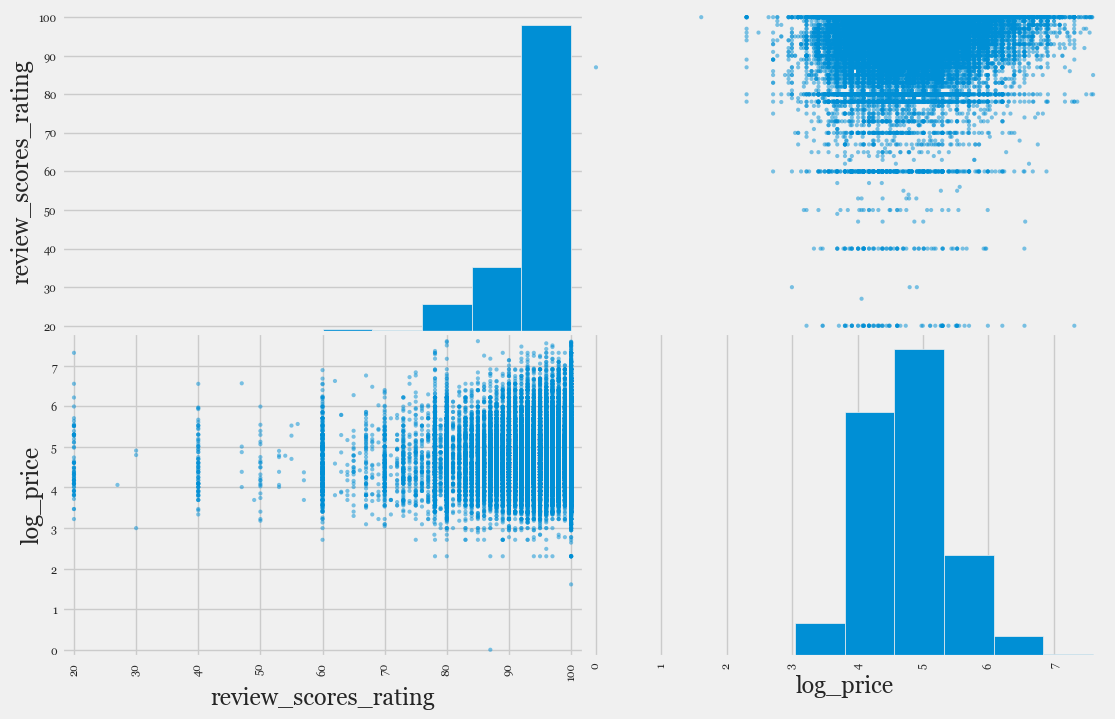

In [308]:
# Univariate, scatter matrix analysis
df_strat_train = strat_train_set.copy()
from pandas.plotting import scatter_matrix
attributes = ['review_scores_rating', 'log_price']
scatter_matrix(df[attributes], figsize=(12, 8))

In [309]:
# Prepare the data for Machine Learning algorithms
# drop labels for training set
df = strat_train_set.drop(['log_price', 'log_price_label'], axis=1) 
df_labels = strat_train_set['log_price'].copy()

In [310]:
# Model training and selection
'''  
predefining the functions meant for different model development and training followed by model optimization and validation via
    # gridsearch: its used to search through the best parameter values from the given set of the grid of parameters. It is basically a cross-validation method.

    # cross validation: The cross_val_score function evaluates the model's performance on each data point, providing a better understanding of the model's behavior and weaknesses for the unseen data

    # randomized search: is a way to find the best values for different parameters by randomly trying out a subset of possible combinations, which makes the search process faster.
'''
# cross validation of models is performed for
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib
   
# to display the score of the model-method deployed
def display_scores(scores):
    print("Scores:", scores, "\n")
    print("Mean:", scores.mean(), "\n")
    print("Standard deviation:", scores.std(), "\n")
    

# Function to get grid search results
def get_hyperparameter_search_results(model, df_train, df_labels, search_type,
                                      param_grid, param_distributions, n_iter, cv):
    search_results = {}
    
    ## train across 5 folds, that's a total of (12+6)*5=90 rounds of training
    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                              scoring='neg_mean_squared_error', return_train_score=True)
    elif search_type == "randomized":
        search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                    n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42,
                                    return_train_score=True)
    else:
        print("Invalid search type", "\n")
        return

    search.fit(df_train, df_labels)
    
    search_results["search"] = search
    search_results["best_params_"] = search.best_params_
    search_results["best_estimator_"] = search.best_estimator_
    search_results["cv_results_"] = search.cv_results_
    
    return search_results


def plot_feature_importance(best_estimator, df_train):
    X = df_train
    importances = best_estimator.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
       print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [311]:
# deploying the learning curves as they show you how the performance of a classifier changes
# helps in the predictive performancd analysis by utlizing the RMSE  method, with another method being R-squared
''' 
Both RMSE and R- Squared quantifies how well a linear regression model fits a dataset. The RMSE tells how well a regression model can predict the value of a response variable in absolute terms while R- Squared tells how well the predictor variables can explain the variation in the response variable.

but RMSE is chosen mostly because For comparing the accuracy among different linear regression models, RMSE is a better choice than R Squared.

Low RMSE values show that the model makes more accurate predictions and fits the data well. Higher levels, on the other hand, imply more significant mistakes and fewer accurate forecasts.

The standards for a good R-squared reading can be much higher, such as 0.9 or above. In finance, an R-squared above 0.7 would generally be seen as showing a high level of correlation, whereas a measure below 0.4 would show a low correlation
'''
from sklearn.model_selection import learning_curve

#train_sizes=[0.25, 0.5, 0.75, 1]
def get_model_pics(model, model_save_name, train_sizes_lc, train_sizes_fittime, ylim):
    train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(model, df_prepared, df_labels, train_sizes=train_sizes_lc, cv=5, scoring="neg_mean_squared_error", return_times=True)
    
    train_rmse = np.sqrt(-train_scores)
    train_rmse_mean = np.mean(train_rmse, axis=1)
    train_rmse_std = np.std(train_rmse, axis=1)

    valid_rmse = np.sqrt(-valid_scores)
    valid_rmse_mean = np.mean(valid_rmse, axis=1)
    valid_rmse_std = np.std(valid_rmse, axis=1)

    
    ### Learning Curve
    plt.figure()
    plt.plot(train_sizes, train_rmse_mean, 'o-', linewidth=2, markersize=8)
    plt.fill_between(train_sizes, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5)
    plt.plot(train_sizes, valid_rmse_mean, 'o-', linewidth=2, markersize=8)
    plt.fill_between(train_sizes, valid_rmse_mean-2*valid_rmse_std, valid_rmse_mean+2*valid_rmse_std, alpha=0.5)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.title("Learning Curve", fontsize=16, fontweight="bold")
    plt.xlabel("Number of training examples", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.legend(["Training", "Validation"])

    
    ### Scalability of models
    # train_sizes=[0.25, 0.5, 0.75, 1]
    train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(model, df_prepared, df_labels, train_sizes=train_sizes_fittime, cv=5, scoring="neg_mean_squared_error", return_times=True)

    valid_rmse = np.sqrt(-valid_scores)
    valid_rmse_mean = np.mean(valid_rmse, axis=1)
    valid_rmse_std = np.std(valid_rmse, axis=1)

    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.figure()
    plt.plot(train_sizes, fit_times_mean, 'o-', linewidth=2, markersize=8, c="#e5ae38")
    plt.fill_between(train_sizes, fit_times_mean-2*fit_times_std, fit_times_mean+2*fit_times_std, alpha=0.5, color="#e5ae38")
    ax = plt.gca()
    ax.set_xscale('log')
    plt.title("Model Scalability", fontsize=16, fontweight="bold")
    plt.xlabel("Number of training examples", fontsize=14)
    plt.ylabel("Time to fit (seconds)", fontsize=14)
    
    ### Model performance
    plt.figure()
    plt.plot(fit_times_mean, train_rmse_mean, 'o-', linewidth=2, markersize=8, c="#6d904f")
    plt.fill_between(fit_times_mean, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5, color="#6d904f")
    plt.title("Model Performance", fontsize=16, fontweight="bold")
    plt.ylabel("Training RMSE", fontsize=14)
    plt.xlabel("Time to fit (seconds)", fontsize=14)

In [312]:
##### LINEAR REGRESSION #####

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model_linreg = LinearRegression()
df_prepared = preprocessing_pipeline.transform(df)
model_linreg.fit(df_prepared, df_labels)
#df_predictions = model_linreg.predict(df_prepared)

pipeline_linreg = Pipeline([
        ("preparation", preprocessing_pipeline),
        ("linear", model_linreg)
    ])
df_predictions = pipeline_linreg.predict(df)

mse_linreg = mean_squared_error(df_labels, df_predictions)
rmse_linreg = np.sqrt(mse_linreg)
print("RMSE: " + str(rmse_linreg))

mae_linreg = mean_absolute_error(df_labels, df_predictions)
print("MAE: " + str(mae_linreg))

r2score = r2_score(df_labels, df_predictions)
print("R2 Score: " + str(r2score))

scores_linreg = cross_val_score(model_linreg, df_prepared, df_labels,scoring="neg_mean_squared_error", cv=10)
rmsescores_linreg = np.sqrt(-scores_linreg)
display_scores(rmsescores_linreg)

'''  
as can be seen the magnitude of error as seen by rmse is considerably large and not small i.e the model is making around 0.40 wrong predictions considering the phenomena being observed with the outliers by the r2 method nearing 0.6

although mae score is low enough nearing about 0.25 having low std deviation

'''

RMSE: 0.4323270413371029
MAE: 0.3356503422093957
R2 Score: 0.5741343052986863
Scores: [0.43102971 0.43180817 0.42836742 0.41921459 0.43360709 0.44436798
 0.43572745 0.43039676 0.44437407 0.42513623] 

Mean: 0.43240294725295064 

Standard deviation: 0.0074044570241398695 



'  \nas can be seen the magnitude of error as seen by rmse is considerably large and not small i.e the model is making around 0.40 wrong predictions considering the phenomena being observed with the outliers by the r2 method nearing 0.6\n\nalthough mae score is low enough nearing about 0.25 having low std deviation\n\n'

In [313]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression

rfe = RFE(estimator=model_linreg, n_features_to_select=5, step=1)
rfe.fit(df_prepared, df_labels)
ranking = rfe.ranking_
ranking

array([6, 1, 4, 1, 1, 1, 7, 2, 1, 3, 5])

"  \nLearning curve tells us that after around 10^3 training examples, its enough data for the model to predict the results as per the performance stated previously and the training score won't change much by adding more examples.\n\nmodel scalalbility shows that further traning example would increase the prediction times considerably, hence not Linear regression is not quite scalable model for this dataset with quite a sread along the mean line\n\nalso the models training rmse value increases and gets saturated at ~ 0.4 i.e the accuracy drops for large amounts of datasets with max timings nearing 0.008 seconds\n\nhence we can conclude that the model is good and scalable for 10^3 samples or few samples of data to get fast and near accuarate results.\n"

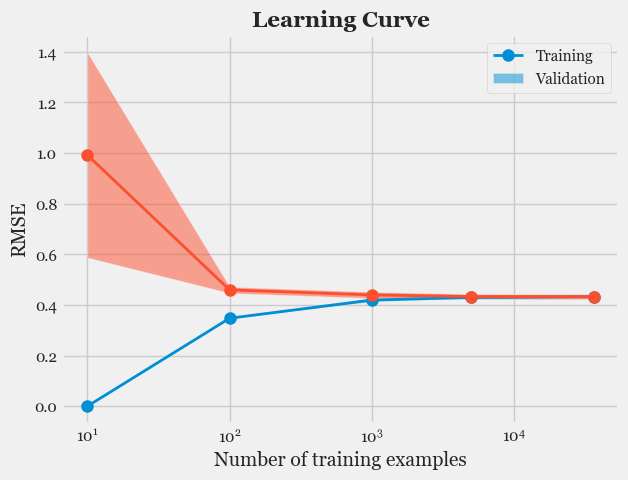

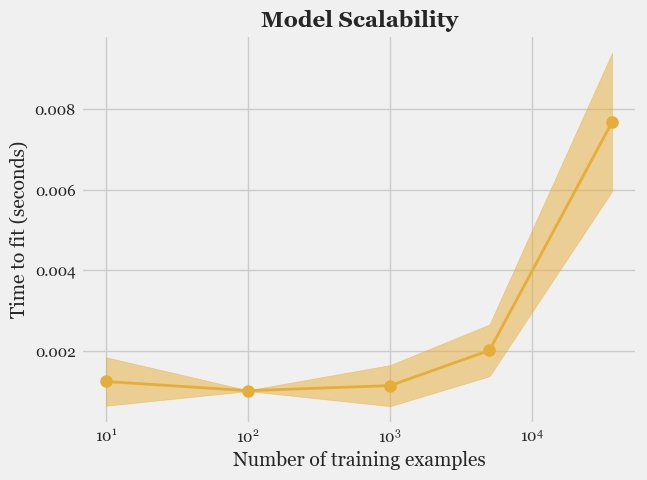

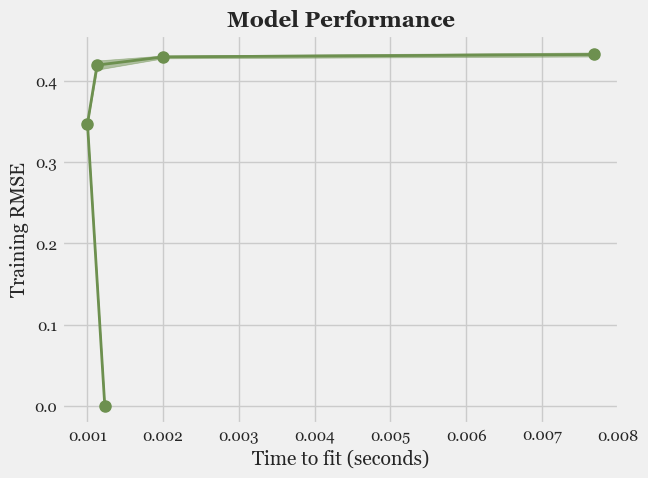

In [314]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(model_linreg, "linreg", [10, 100, 1000, 5000, 36540],
               [10, 100, 1000, 5000, 36540], [0, 0.06])

'''  
Learning curve tells us that after around 10^3 training examples, its enough data for the model to predict the results as per the performance stated previously and the training score won't change much by adding more examples.

model scalalbility shows that further traning example would increase the prediction times considerably, hence not Linear regression is not quite scalable model for this dataset with quite a sread along the mean line

also the models training rmse value increases and gets saturated at ~ 0.4 i.e the accuracy drops for large amounts of datasets with max timings nearing 0.008 seconds

hence we can conclude that the model is good and scalable for 10^3 samples or few samples of data to get fast and near accuarate results.
'''

In [315]:
# cross validation:
scores_linreg = cross_val_score(pipeline_linreg, df, df_labels, scoring="neg_mean_squared_error", cv=10)
rmsescores_linreg = np.sqrt(-scores_linreg)
display_scores(rmsescores_linreg)

Scores: [0.43102971 0.43180817 0.42836742 0.41921459 0.43360709 0.44436798
 0.43572745 0.43039676 0.44437407 0.42513623] 

Mean: 0.43240294725295064 

Standard deviation: 0.007404457024139817 



In [316]:
##### Decision Tree Regressor #####
''' 
Decision Tree Regression builds a tree like structure by splitting the data based on the values of various features. Simply it creates different subsets of data. For prediction of new sample or data, average value of target variable from leaf node is used. It handles both categorical and continues variables, making it versatile algorithm for regression tasks.

But in some libraries of python like sklearn categorical variable can not be handled by decision tree regression. So we have to encode it using any encoder method, according to data or model.
'''

from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint


tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, df_labels)

df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
print("tree_rmse: ")
print(tree_rmse, "\n")

# Cross Validation
scores = cross_val_score(tree_reg, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("tree_rmse_scores: ")
display_scores(tree_rmse_scores)
print("\n")


print("========= Decision Tree Regressor =========")
default_model_dectree = DecisionTreeRegressor(random_state=42)
default_model_dectree.fit(df_prepared, df_labels)
df_predictions = default_model_dectree.predict(df_prepared)

mse_default_model_dectree = mean_squared_error(df_labels, df_predictions)
rmse_default_model_dectree = np.sqrt(mse_default_model_dectree)
print("Model: ")
print(default_model_dectree, "\n")
print("Default Model RMSE Score: " + str(rmse_default_model_dectree), "\n")

scores = cross_val_score(default_model_dectree, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)
print("\n")


model_dectree = DecisionTreeRegressor(random_state=42)
param_grid = [
    {'max_depth': [1, 20, 100], 'max_features': [1, 5, 15, 20], 'max_leaf_nodes': [5, 50, 100]},
  ]
search_results_dectree = get_hyperparameter_search_results(model=model_dectree, df_train=df_prepared, df_labels=df_labels, search_type="grid", param_grid=param_grid, param_distributions=None, n_iter=5, cv=2)

# Best estimator (hyperparameter combination) found
print("========= Best Parameters: =========")
print(search_results_dectree["best_params_"], "\n")
print("========= Best Estimator: =========")
print(search_results_dectree["best_estimator_"], "\n")

print("========= Cross Validation Results =========")

# score of each hyperparameter combination tested during the grid search
cvres = search_results_dectree["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
best_dectree = search_results_dectree["best_estimator_"]

## has a good rmse score as its quite less in comparison to the linear regressor model along with a low std deviation and a mean above 0.5
# features for hyperparameter tuning are noted as follows:
# DecisionTreeRegressor(max_depth=20, max_features=15, max_leaf_nodes=100) 

tree_rmse: 
0.18792282556851073 

tree_rmse_scores: 
Scores: [0.53524754 0.53927123 0.53307484 0.53638342 0.53679994 0.54213511
 0.54579404 0.53834771 0.54360153 0.53033716] 

Mean: 0.538099253106713 

Standard deviation: 0.00453285367784377 



========= Decision Tree Regressor =========
Model: 
DecisionTreeRegressor(random_state=42) 

Default Model RMSE Score: 0.18792282556851073 

Scores: [0.53524754 0.53927123 0.53307484 0.53638342 0.53679994 0.54213511
 0.54579404 0.53834771 0.54360153 0.53033716] 

Mean: 0.538099253106713 

Standard deviation: 0.00453285367784377 



========= Best Parameters: =========
{'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': 100} 

========= Best Estimator: =========
DecisionTreeRegressor(max_depth=20, max_features=15, max_leaf_nodes=100,
                      random_state=42) 

========= Cross Validation Results =========
0.5849139179825883 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 5}
0.5849139179825883 {'max_depth': 1, 'max_features

Text(0.5, 1.0, 'Tuning Max Leaf Nodes (Max Depth=10, Max features=15)')

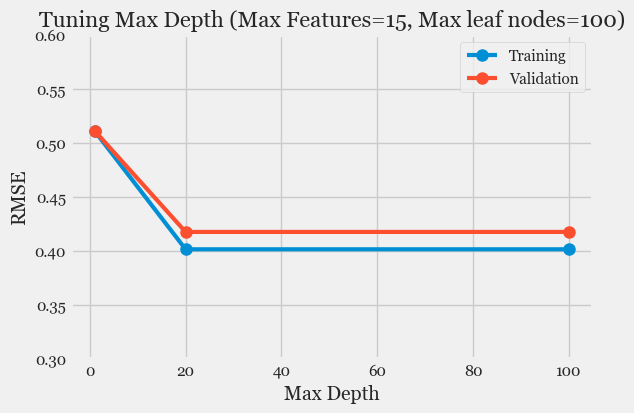

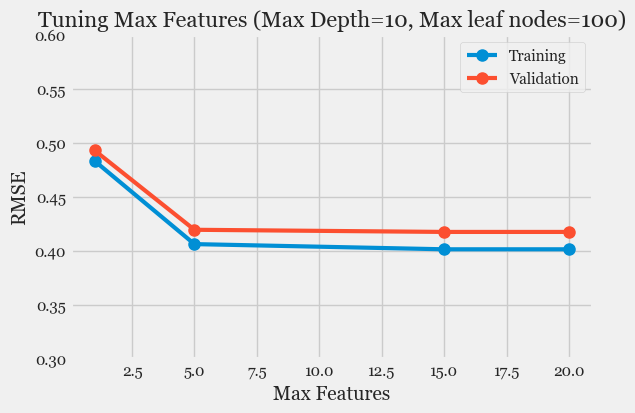

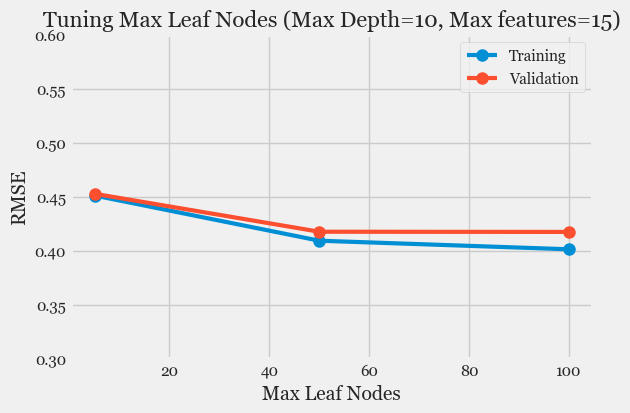

In [317]:
# Hyperparameter tuning
''' 
Hyperparameter Tuning
Hyperparamter Tuning means we have to select the best values for parameters of algorithm in machine learning. It includes searching and evaluating different combinations of parameters to maximize the performance of model.

To enhance the performance of decision tree regression we can tune its parameters using methods in library like GridSearchCV and RandomizedSearchCV.
'''

''' 
hyperparameters involved:

    # criterion : Decides the measure of the quality of a split based on criteria like “gini” for the Gini impurity and “entropy” for the information gain.

    # max_depth : The maximum depth of the tree, the more depth of tree generally it overfits the data.

    # max_leaf_nodes : Grows the tree with a specified number of leaf nodes based on reduction in impurity.
    
    # min_samples_split : The minimum number of samples that are required to split an internal node.
    
    # min_samples_leaf : The minimum number of samples that are required to be at a leaf node of the tree.
    
For Tree models, usually, lowering the values of max_ parameters and increasing values of min_ parameters results in a better and stable model.
'''

# comparison between validation and training is done to observe the closeness of the params just found

# Max Features
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_features = 15
max_leaf_nodes = 100
# for mean_score, evaluate params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_features"]==max_features) and (params["max_leaf_nodes"]==max_leaf_nodes):
        hparams.append(params["max_depth"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.3, 0.6])
plt.title("Tuning Max Depth (Max Features=15, Max leaf nodes=100)", fontsize=16)

# Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 20
max_leaf_nodes = 100
# for mean_score, evaluate params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_leaf_nodes"]==max_leaf_nodes):
        hparams.append(params["max_features"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Features", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.3, 0.6])
plt.title("Tuning Max Features (Max Depth=10, Max leaf nodes=100)", fontsize=16)


# Max leaf nodes
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 20
max_features = 15
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_features"]==max_features):
        hparams.append(params["max_leaf_nodes"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Leaf Nodes", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.3, 0.6])
plt.title("Tuning Max Leaf Nodes (Max Depth=10, Max features=15)", fontsize=16)

Text(0.5, 1.0, 'Feature Importance (Decision Tree)')

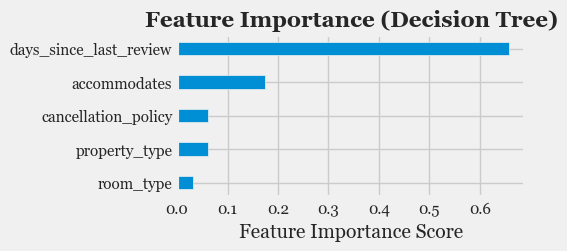

In [318]:
# Feature importance according to the decsion tree classifier for its overall contribution to log_price
features = dfcl.columns
score = best_dectree.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,2))
plt.barh(features_sorted[:5][::-1], score_sorted[:5][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Decision Tree)", fontsize=16, fontweight="bold")

" \nlearning curve suggests that the  umber of samples gets saturated for further accuracy after 10^4 training examples\n\nmodel is quite scalable even though the time increases (as it should for large number of datasets) as the variation for each time is not much deviated from the mean predicted line\n\nmodel's performance is better than the linear regression ones as even for higher datasets,m it takes lesser time than the lower number of datasets to process by the linear regression one\n"

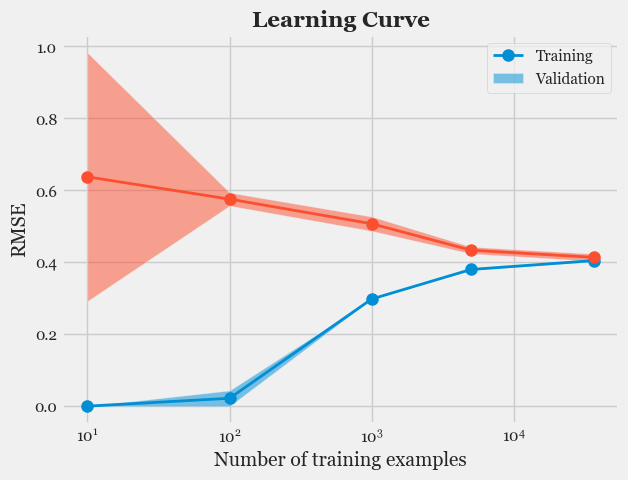

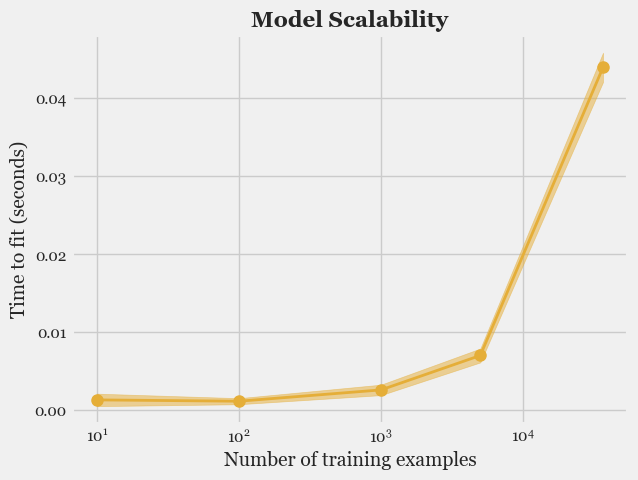

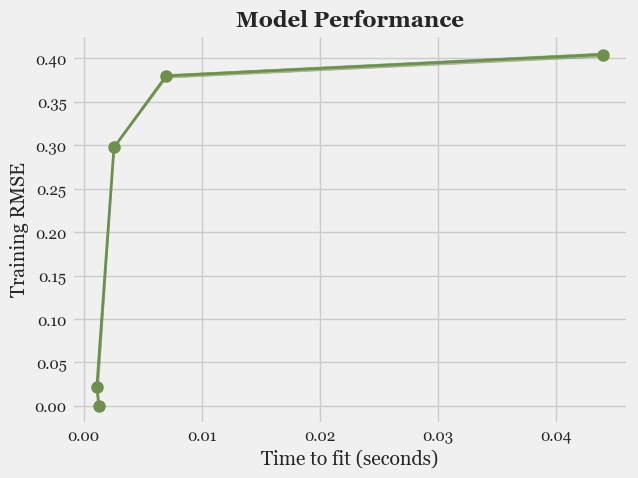

In [319]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(best_dectree, "dectree", [10, 100, 1000, 5000, 36540],
               [10, 100, 1000, 5000, 36540], [0, 0.04])

''' 
learning curve suggests that the  umber of samples gets saturated for further accuracy after 10^4 training examples

model is quite scalable even though the time increases (as it should for large number of datasets) as the variation for each time is not much deviated from the mean predicted line

model's performance is better than the linear regression ones as even for higher datasets,m it takes lesser time than the lower number of datasets to process by the linear regression one
'''

In [320]:
##### Random Forest Regressor #####
''' 

'''

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from scipy import stats

# Regression with set fixed values of model parameters
default_model_rf = RandomForestRegressor(n_estimators=10, random_state=42)
default_model_rf.fit(df_prepared, df_labels)
df_predictions = default_model_rf.predict(df_prepared)
mse_default_model_rf = mean_squared_error(df_labels, df_predictions)
rmse_default_model_rf = np.sqrt(mse_default_model_rf)
print("rmse_default_model_rf: ")
print(rmse_default_model_rf, "\n")

# Cross Validation Scores
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, df_prepared, df_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("forest_rmse_scores: ")
display_scores(forest_rmse_scores)
print("\n")




# Grid Search (to find best parameters) CV
param_grid = [
    # tried 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then tried 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
## train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df_prepared, df_labels)

# Best estimator (hyperparameter combination) found
print(grid_search.best_params_, "\n")
print(grid_search.best_estimator_, "\n")

# score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# Randomized Search (to find best parameters) CV 
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(df_prepared, df_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)




model_rf = RandomForestRegressor(random_state=42)
# can also add {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
param_grid = [
    {'n_estimators': [3, 10, 100], 'max_features': [2, 10, 20], 'max_depth': [2, 10, 100]},
  ]
search_results_rf = get_hyperparameter_search_results(model=model_rf, df_train=df_prepared, df_labels=df_labels, search_type="grid", param_grid=param_grid, param_distributions=[], n_iter=5, cv=2)
best_rf = search_results_rf["best_estimator_"]

# Best estimator (hyperparameter combination) found
print("======Best Parameters: ======")
print(search_results_rf["best_params_"], "\n")
print("======Best Estimator: ======")
print(search_results_rf["best_estimator_"], "\n")

print("====== Cross Validation Results ======")
# score of each hyperparameter combination tested during the grid search
cvres = search_results_rf["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# Feature Importance
feature_importances = search_results_rf["best_estimator_"].feature_importances_
attributes = numerical_attribs + categorical_attribs

# best params noted {'max_depth': 10, 'max_features': 10, 'n_estimators': 100}
# it has considerable low rmse score but a bit higher than the decision tree
# it has the least deviation in comparison to linear and decision tree regressors 

rmse_default_model_rf: 
0.24461345505336557 

forest_rmse_scores: 
Scores: [0.42537647 0.42215013 0.42000376 0.41843444 0.4268824  0.43963439
 0.43102788 0.42409769 0.43348525 0.41916536] 

Mean: 0.4260257751853186 

Standard deviation: 0.00653231342259128 



{'max_features': 2, 'n_estimators': 30} 

RandomForestRegressor(max_features=2, n_estimators=30, random_state=42) 

0.4632144866673515 {'max_features': 2, 'n_estimators': 3}
0.432121724530598 {'max_features': 2, 'n_estimators': 10}
0.4236162137707581 {'max_features': 2, 'n_estimators': 30}
0.4644440078079561 {'max_features': 4, 'n_estimators': 3}
0.43279256645798214 {'max_features': 4, 'n_estimators': 10}
0.424417570222961 {'max_features': 4, 'n_estimators': 30}
0.4654822253665317 {'max_features': 6, 'n_estimators': 3}
0.4343791905369857 {'max_features': 6, 'n_estimators': 10}
0.42540075395261867 {'max_features': 6, 'n_estimators': 30}
0.4692947006218151 {'max_features': 8, 'n_estimators': 3}
0.4364122989875053 {'max_features': 8

' \nmax depth with rmse after tuning shows increasing deviation between training and the validation methods suggesting there could be further scope to improve this hyper params\nmax features and no. estimators correlation with the rmse is nearly constant and acceptable\n'

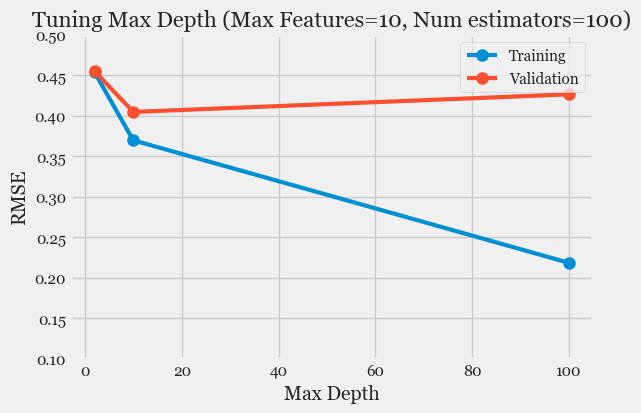

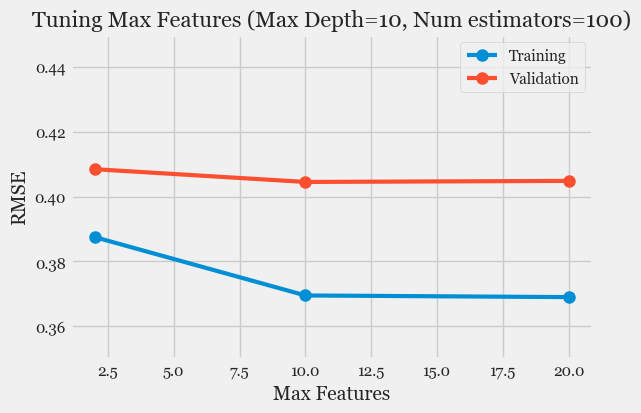

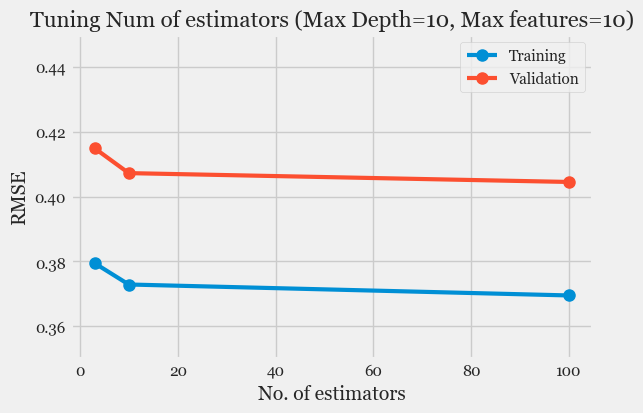

In [321]:
### Hyperparameter tuning
''' 
Random Forest Hyperparameters
    # n_estimators: n_estimator is the hyperparameter that defines the number of trees to be used in the model. The tree can also be understood as the sub-divisions.

    #  max_features: In order to train the model, the given dataset should contain multiple features/variables to predict the label/target. Max_features limits a count to select the maximum features in each tree. 

    # max_depth: determines the maximum number of splits each tree can take. If the max_depth is too low, the model will be trained less and have a high bias, leading the model to underfit & if max_depth is high, the model learns too much and leads to high variance, leading the model to overfit.

    # max_leaf_nodes: max_leaf_nodes restricts the growth of each tree  by specifying how many divisions of nodes should be done.

    # max_sample: determines how much of the dataset is given to each individual tree.

    # min_sample_split: determines the minimum number of decision tree observations in any given node in order to split. 
'''

### Max Features
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_features = 10
n_estimators = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_features"]==max_features) and (params["n_estimators"]==n_estimators):
        hparams.append(params["max_depth"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.1, 0.5])
plt.title("Tuning Max Depth (Max Features="+str(max_features)+", Num estimators="+str(n_estimators)+")", fontsize=16)


### Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 10
n_estimators = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["n_estimators"]==n_estimators):
        hparams.append(params["max_features"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Features", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.35, 0.45])
plt.title("Tuning Max Features (Max Depth="+str(max_depth)+", Num estimators="+str(n_estimators)+")", fontsize=16)


### Max leaf nodes
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 10
max_features = 10
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_features"]==max_features):
        hparams.append(params["n_estimators"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("No. of estimators", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.35, 0.45])
plt.title("Tuning Num of estimators (Max Depth="+str(max_depth)+", Max features="+str(max_features)+")", fontsize=16)

''' 
max depth with rmse after tuning shows increasing deviation between training and the validation methods suggesting there could be further scope to improve this hyper params
max features and no. estimators correlation with the rmse is nearly constant and acceptable
'''

In [322]:
# cross_validation results
cvres

{'mean_fit_time': array([0.01051402, 0.02502847, 0.21867895, 0.01966739, 0.0582813 ,
        0.58122754, 0.01959181, 0.05822206, 0.56135392, 0.02229166,
        0.06461143, 0.62186074, 0.06390274, 0.1977272 , 2.1272614 ,
        0.07049572, 0.2234416 , 2.19786239, 0.05709291, 0.18026042,
        1.82101142, 0.12996972, 0.43105078, 4.28611314, 0.14304972,
        0.4583689 , 4.80930483]),
 'std_fit_time': array([3.71694565e-04, 2.51770020e-04, 3.40008736e-03, 2.65836716e-04,
        2.31385231e-04, 4.77266312e-02, 6.24656677e-05, 1.19209290e-06,
        5.74278831e-03, 5.41925430e-04, 4.87565994e-04, 4.31370735e-03,
        2.65955925e-04, 1.95026398e-04, 8.22534561e-02, 1.72531605e-03,
        3.98898125e-03, 4.03618813e-02, 2.01845169e-03, 4.10079956e-04,
        2.44926214e-02, 1.57487392e-03, 3.96490097e-03, 3.02811861e-02,
        2.44760513e-03, 1.31642818e-03, 9.77655649e-02]),
 'mean_score_time': array([0.00235927, 0.00496066, 0.03760874, 0.00200689, 0.00568962,
        0.042972

Text(0.5, 1.0, 'Feature Importance (Random Forest)')

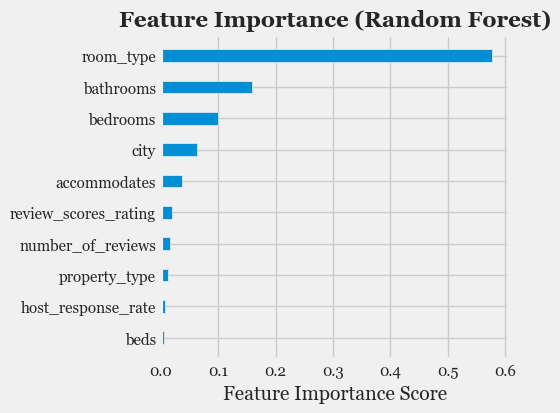

In [323]:
# Feature importance as per the random forest regressor
# highest for room_types wrt log_price
features = df.columns
score = best_rf.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Random Forest)", fontsize=16, fontweight="bold")

'  \nobservation of the learning curve tells us that more data is required for better fitting and possibly training sets of nearing 10^5\n\nnot good scalability as it takes a lot of time for predicition though results are almost accurate as the decision tree and does better justice to the outliers in the data present \n\n# model performance graph shows it takes a considerable amount of time as compared to linear and decision tree regressor and gets beaten bybthose 2 regressors in terms if time taken for even small data sets.\n'

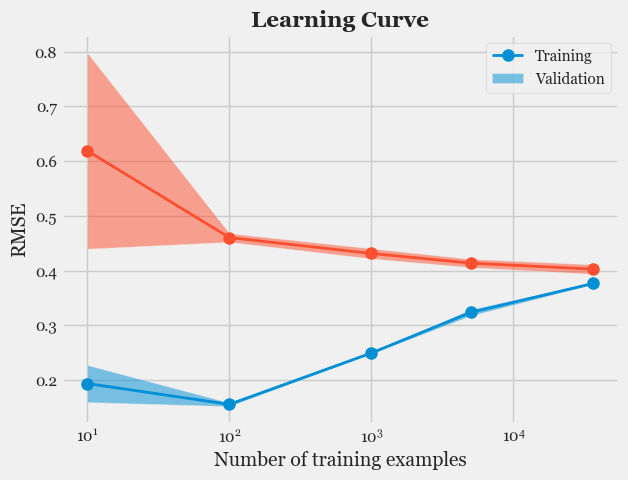

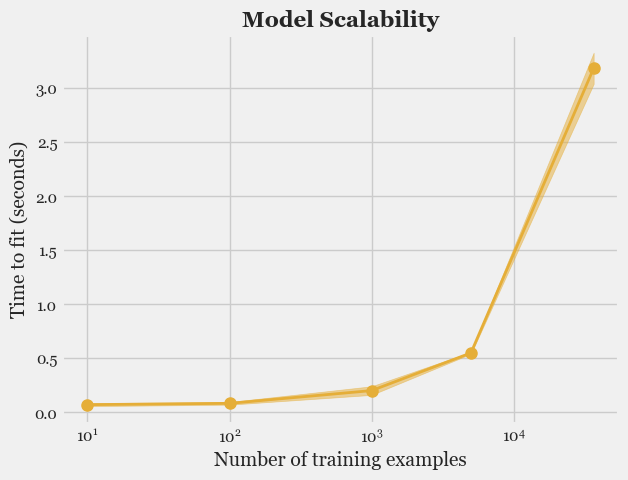

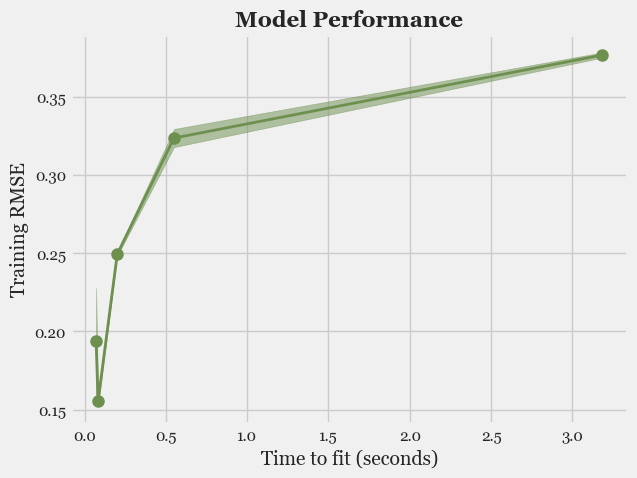

In [324]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(best_rf, "rf", [10, 100, 1000, 5000, 36540],
               [10, 100, 1000, 5000, 36540], [0, 0.04])

'''  
observation of the learning curve tells us that more data is required for better fitting and possibly training sets of nearing 10^5

not good scalability as it takes a lot of time for predicition though results are almost accurate as the decision tree and does better justice to the outliers in the data present 

# model performance graph shows it takes a considerable amount of time as compared to linear and decision tree regressor and gets beaten bybthose 2 regressors in terms if time taken for even small data sets.
'''

In [325]:
##### XGBoost #####
''' 
In this algorithm, decision trees are created in sequential form. Weights play an important role in XGBoost. Weights are assigned to all the independent variables which are then fed into the decision tree which predicts results. The weight of variables predicted wrong by the tree is increased and these variables are then fed to the second decision tree. These individual classifiers/predictors then ensemble to give a strong and more precise model. It can work on regression, classification, ranking, and user-defined prediction problems.
'''

from sklearn import datasets, ensemble
import xgboost as xgb

dfx = dfcl.copy()
del dfx["log_price"]
dfy = dfcl["log_price"].copy()
x_train, x_test, y_train, y_test = train_test_split(dfx,dfy, test_size=0.1, random_state=42)
xgb_train = xgb.DMatrix(x_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(x_test, y_test, enable_categorical=True)

params = {'n_estimators': 100,
          'max_depth': 10,
          'min_samples_split': 11,
          'learning_rate': 0.01}

default_model_xgb = ensemble.GradientBoostingRegressor(**params)
default_model_xgb.fit(df_prepared, df_labels)

xgbr_reg = xgb.XGBRegressor(objective ='reg:linear', n_estimators = 100, seed = 123) 
xgbr_reg.fit(x_train, y_train)
mse = mean_squared_error(y_test, xgbr_reg.predict(x_test))

default_xgb_scores = cross_val_score(default_model_xgb, df_prepared, df_labels,
                               scoring="neg_mean_squared_error", cv=2)
default_xgb_rmse_scores = np.sqrt(-default_xgb_scores)
display_scores(default_xgb_rmse_scores)

# lowest amount of deviation amongst the model used yet having mean of around 0.5 on the lower side

Scores: [0.44515921 0.45249395] 

Mean: 0.4488265803653613 

Standard deviation: 0.0036673695703204334 



# 10. Predictive Performance Assessment:
## Task: Critically evaluate the performance of the final model on a reserved test set. 
Use metrics such as Root Mean Squared Error (RMSE) and R-squared to assess accuracy and goodness of fit. Provide a detailed analysis of the residuals to check for any patterns that might suggest model biases or misfit

In [326]:
# Model comparison using test data results function declaration: 
def get_test_results(strat_test_set, preprocessing_pipeline, final_model):
    
    test_results = {}
    X_test = strat_test_set.drop(['log_price', 'log_price_label'], axis=1)
    y_test = strat_test_set['log_price'].copy()

    ### Full pipeline with pre-processing and model
    full_pipeline = Pipeline([
            ("preparation", preprocessing_pipeline),
            ("model", final_model)
        ])
    final_predictions = full_pipeline.predict(X_test)
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)

    ## 95% confidence interval for the test RMSE
    confidence = 0.95
    squared_errors = (final_predictions - y_test) ** 2
    mean = squared_errors.mean()
    m = len(squared_errors)

    confidence_interval_95 = np.sqrt(stats.t.interval(confidence, m - 1,
                             loc=np.mean(squared_errors),
                             scale=stats.sem(squared_errors)))
    
    test_results["labels"] = y_test
    test_results["predictions"] = final_predictions
    test_results["squared_errors"] = squared_errors
    test_results["mse"] = final_mse
    test_results["rmse"] = final_rmse
    test_results["errors"] = np.sqrt(squared_errors)
    test_results["interval_95"] = confidence_interval_95
    
    return test_results

In [327]:
linreg = get_test_results(strat_test_set, preprocessing_pipeline, model_linreg)
dectree = get_test_results(strat_test_set, preprocessing_pipeline, best_dectree)
rf = get_test_results(strat_test_set, preprocessing_pipeline, best_rf)
xgb = get_test_results(strat_test_set, preprocessing_pipeline, default_model_xgb)

' \nfor the given conclusion graph, random forest and decision tree prove to be the best models for the given dataset based on the processing time the rmse error range lying in between 0.2 and 0.4 with them also being scalable for a larger datasets as well only for decision tree\n\nhence among decision tree and random forest for larger datasets, decision tree is prefereed\n\nlinear regression and xgboost (untuned) are inefficient for the given dataset\n'

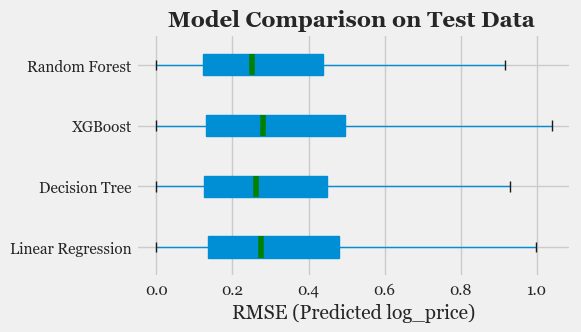

In [328]:
dft = pd.DataFrame()
dft["Linear Regression"] = linreg["errors"]
dft["Decision Tree"] = dectree["errors"]
dft["XGBoost"] = xgb["errors"]
dft["Random Forest"] = rf["errors"]
plt.figure(figsize=(5,3))
dft.boxplot(showfliers=False, patch_artist=True, medianprops=dict(linestyle='-', linewidth=4, color='green'), vert=False, widths=0.35)
ax = plt.gca()
ax.set_xlabel("RMSE (Predicted log_price)", fontsize=14)
ax.set_title("Model Comparison on Test Data ", fontsize=16, fontweight="bold")

''' 
for the given conclusion graph, random forest and decision tree prove to be the best models for the given dataset based on the processing time the rmse error range lying in between 0.2 and 0.4 with them also being scalable for a larger datasets as well only for decision tree

hence among decision tree and random forest for larger datasets, decision tree is prefereed

linear regression and xgboost (untuned) are inefficient for the given dataset
'''